In [25]:
import json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.image as mpimg
from protocols import utils
from catomatic.CatalogueBuilder import BuildCatalogue

from protocols.predict_2 import piezo_predict
from scipy.stats import pearsonr

plt.rcParams['figure.dpi']=250
plt.rcParams['font.family'] = 'Helvetica'  
plt.rcParams['font.size'] = 7
plt.rcParams['figure.figsize']= (6.69, 5.02)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This notebooks deep dives into our training data, and investigates statistical power and heteroresistance with the aim of developing a tailored method for algorithmically phenotyping mutations thought to confer resistance to Bedaquiline using frequentist statistics.

## Data prep

This preperation is all explained in manuscript.ipynb

In [26]:
phenotypes_cryptic = pd.read_csv("./data/DST_MEASUREMENTS_BDQ_CRYPTIC.csv.gz", index_col=0)
phenotypes_nicd = pd.read_csv("./data/DST_MEASUREMENTS_BDQ_NICD.csv.gz", index_col=0)

mutations = pd.read_csv('./data/MUTATIONS_BDQ.csv.gz', index_col=0)

mutations["MUTATION"] = mutations.apply(
    lambda x: f"{x['GENE']}@{x['MINOR_MUTATION'] if x['IS_MINOR_ALLELE'] else x['MUTATION']}",
    axis=1,
)
mutations["IS_SYNONYMOUS"] = mutations["MUTATION"].apply(
    lambda x: x.split("@")[-1][0] == x.split("@")[-1][-1]
)
mutations["FRS"] = mutations.apply(
    lambda x: 1 if not x["IS_MINOR_ALLELE"] else x["FRS"], axis=1
)
cat_mutations = mutations[~mutations["IS_SYNONYMOUS"]].copy()

genomes = pd.read_csv("./data/GENOMES.csv.gz", index_col=0)

phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.METHOD_3.isin(['UKMYC5','UKMYC6'])]
phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.QUALITY=='HIGH']

has_mgit = phenotypes_nicd[phenotypes_nicd.METHOD_CC=='WHO'].index

phenotypes_nicd = phenotypes_nicd[
    phenotypes_nicd.index.isin(has_mgit) & phenotypes_nicd.index.isin(genomes.index)
]
phenotypes_nicd.reset_index(inplace=True)
phenotypes_nicd = phenotypes_nicd.groupby("UNIQUEID").apply(utils.filter_multiple_phenos)
phenotypes_nicd.reset_index(drop=True, inplace=True)
phenotypes_nicd.set_index('UNIQUEID', inplace=True)

phenotypes = pd.concat([phenotypes_cryptic, phenotypes_nicd]) 
samples = phenotypes.join(genomes, how="inner")[["DRUG", "SOURCE", "METHOD_3", "PHENOTYPE", "METHOD_MIC"]]

all_cat = cat_mutations.join(samples, how='right')
all = mutations.join(samples, how='right')

with open('./wildcards/bdq_wildcards.json') as f:
    piezo_wildcards = json.load(f)

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_3849/1369263056.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  phenotypes_nicd = phenotypes_nicd.groupby("UNIQUEID").apply(utils.filter_multiple_phenos)


In [27]:
#although we've joined dataframes on the index column, catomatic uses a distinct UNIQUEID column
all.reset_index(inplace=True)
mutations.reset_index(inplace=True)
cat_mutations.reset_index(inplace=True)
samples.reset_index(inplace=True)


# Introduction

Inspired by, and to improve on previous work [1,2,3], we have developed a tool that allows one to algorithmically construct amr mutation catalogues that satisfy the following aims:
- entirely reproducible
- parameter flexibility
- all statistical evidence is recorded
- catalogues saved in a parsable format

https://github.com/fowler-lab/catomatic [4]


The logic (irrespective of the specific approach/algorithm) relies on the Definite Defectives algorithm, as used in previous work [1,2,3]. Mutations that exist in isolation are extracted and a hypothesis test is run against their Resistant (R) vs Susceptible (S) counts. If classified susceptible, they are removed to proffer additional relevant variants. Once no susceptible mutations in isolation are left, remaining mutations are finally classified.


However, for the purposes of data analysis, we do not have to run an actual hypothesis test - solo mutations can be extracted and their evidence (proportions, confidence intervals etc) can be logged in catalogue format. A practical benefit of this approach, is it allows us to easily examine the underlying data and evidence by prying casual relationships apart. 




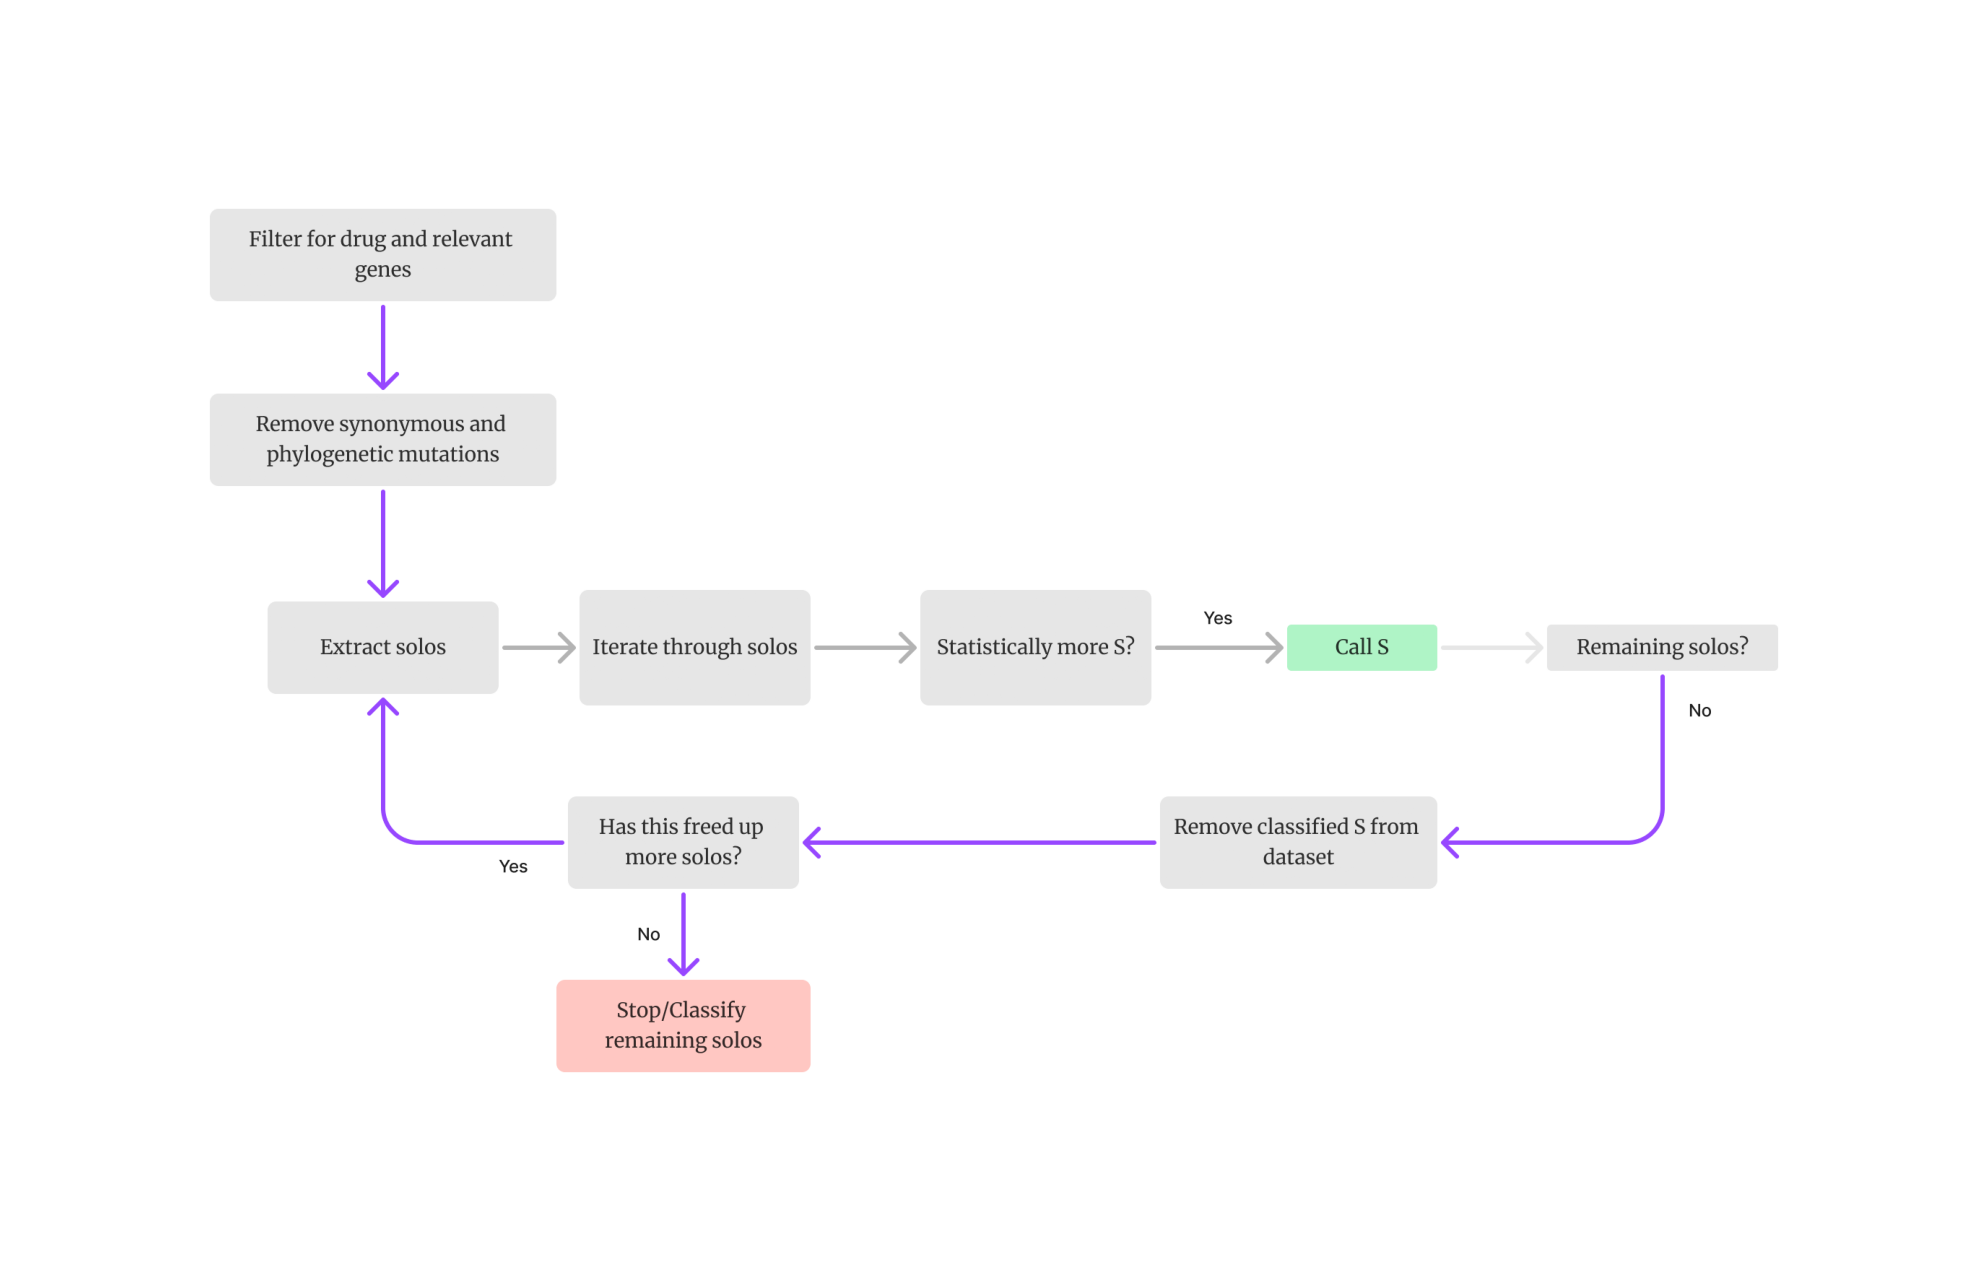

In [28]:
img = mpimg.imread('./imgs/manuscript/naive_workflow.png')
plt.figure(figsize=(10, 10)) 
plt.imshow(img)
plt.axis('off')  
plt.show()

However, to develop an accurate and informative catalogue for Bedaquiline (BDQ) we do need to determine what hypothesis test to use by examining mutation distributions in our data...


## Heuristic methods use a prior

We need to decide whether to use a heuristic system or a frequentist test to classify variants.

Walker2015 [1] is heuristic and extracts variants that occur in isolation, filters out sample counts lower than 3, and then calls any heterogeneity R and homogenous variant S, and does not use a hypothesis test. Susceptible variants are removed from the dataset and the method repeats once: 


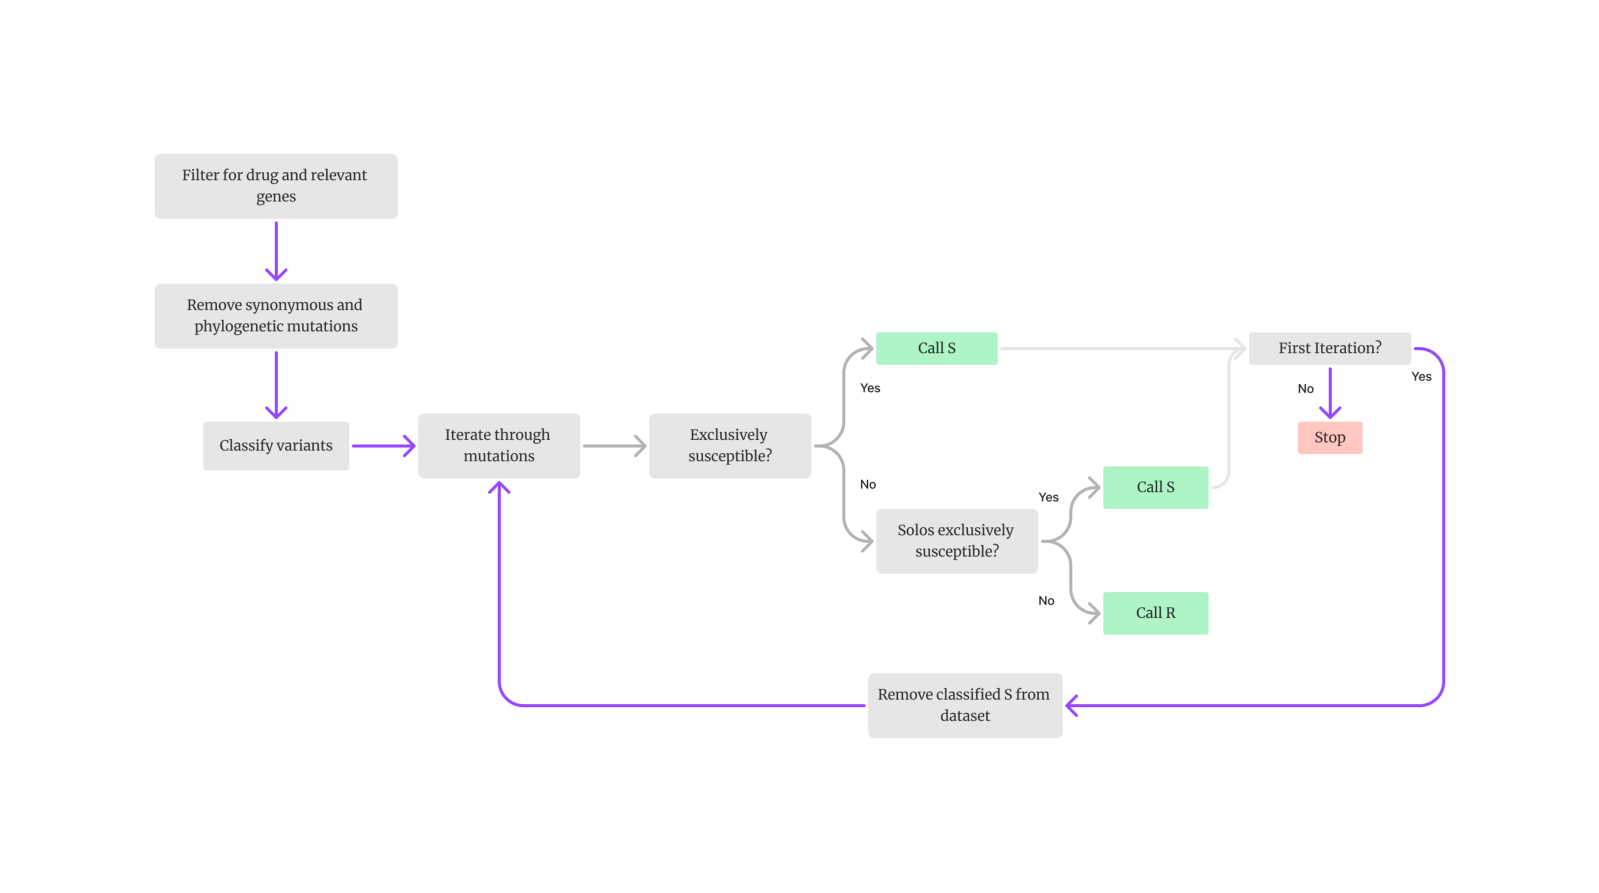

In [29]:
img = mpimg.imread('./imgs/manuscript/walker2015_workflow.png')
plt.figure(figsize=(8, 8)) 
plt.imshow(img)
plt.axis('off')  
plt.show()

This implicilty uses a prior assumption of high penetrance - resistant associated variants will always lead to a resistant phenotype, and therefore variants only seen in susceptible samples will never cause resitance, regarldess of statistical power. In practise this works well for essential genes where resistance is conferred by a relatively small number of well defined, high frequcny mutations, and where the conditional probability of a novel or low-frequency site significantly raising the MIC is low. 

Therefore, it performs well on drugs with clear bimodal MIC distributions and no phenotype heterogeneity.

BDQ, however, is a different story:

## High variance with low statistical power

In [30]:
print ('Mean number of mutations per sample:', len(all)/all.UNIQUEID.nunique())

Mean number of mutations per sample: 2.161540406168366


In [31]:
print ('Mean number of mutaitons per sample, excluding mmpL5 phylogenetic mutations:', len(all[~all.MUTATION.isin(['mmpL5@I948V', 'mmpL5@T794I', 'mmpL5@D767N'])])/all.UNIQUEID.nunique())

Mean number of mutaitons per sample, excluding mmpL5 phylogenetic mutations: 0.3568719979775849


After removal of mmpL5 phylogenetic susceptible mutations ('mmpL5@I948V', 'mmpL5@T794I', 'mmpL5@D767N'), the vast majority of variants are seen in Rv0678 and mmPL5:

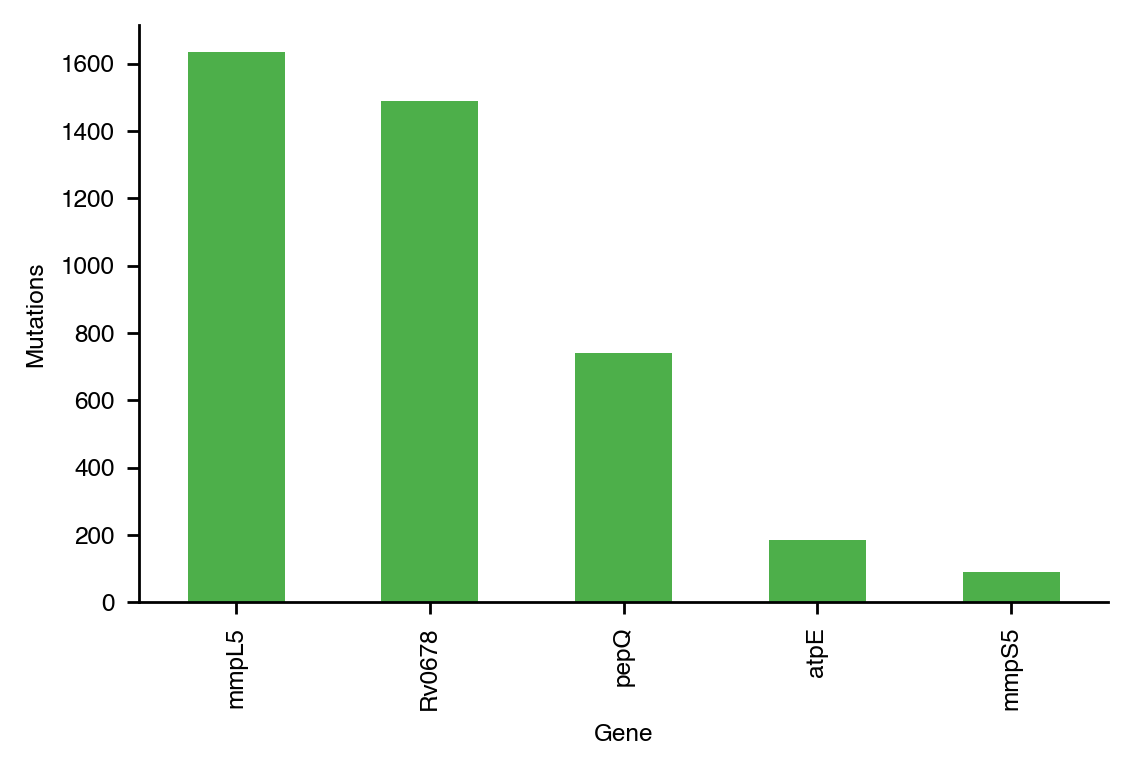

In [32]:
#This needs to match the tables in the results notebook (careful with phylogenetics).
gene_counts = all[~all.MUTATION.isin(['mmpL5@I948V', 'mmpL5@T794I', 'mmpL5@D767N'])]['GENE'].value_counts()

# Plot histogram
fig, ax = plt.subplots(figsize=(5, 3))
gene_counts.plot(kind='bar', color='#4daf4a', edgecolor=None, ax=ax)

# Customize plot appearance
ax.set_xlabel('Gene')
ax.set_ylabel('Mutations')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig('pdf/supplement/fig-gene-mutations.pdf', bbox_inches='tight',transparent=True)
plt.show() 

However, there is no real evidence supporting resistance association for variants in mmpL5, and our data strongly supports this; there are no resistant samples containing only a mutation in mmpL5 across candidate genes:

In [33]:
ids, solos = all.UNIQUEID.unique(), []
for i in ids:
    df = all[all.UNIQUEID == i]
    if len(df) == 1:
        solos.append(i)

print ('number of resistant mmpL5 solos:', len(all[(all.UNIQUEID.isin(solos))&(all.GENE=='mmpL5')&(all.PHENOTYPE=='R')&(~all.MUTATION.isin(['mmpL5@I948V', 'mmpL5@T794I', 'mmpL5@D767N']))]))

number of resistant mmpL5 solos: 0


Instead, the majority of resistance can be attributed to variants in Rv0678.

However, Rv0678 non-essential nature is immediately evident; there is a huge spread of different mutations, with the vast majority existing as singletons:

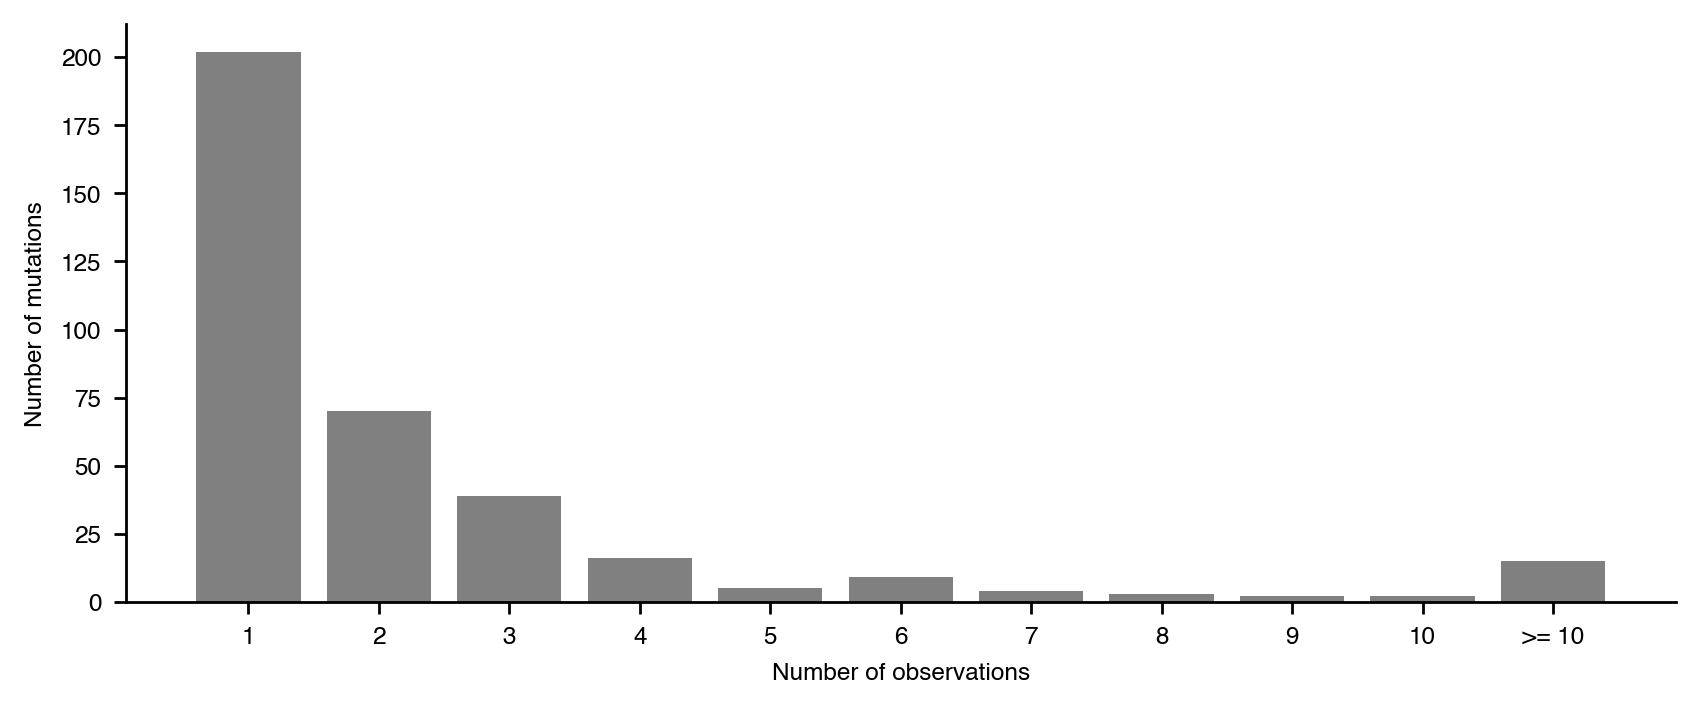

In [34]:
obs = dict(all[all.GENE=='Rv0678'].MUTATION.value_counts())

bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, float('inf')]
distribution = {bin: 0 for bin in bins}

for count in obs.values():
    for bin in bins:
        if count <= bin:
            distribution[bin] += 1
            break

x_labels = [str(i) for i in range(1, 11)] + ['>= 10']
y_values = [distribution[bin] for bin in bins]

plt.figure(figsize=(8, 3))
plt.bar(x_labels, y_values, color='grey')  
plt.xlabel('Number of observations')
plt.ylabel('Number of mutations')

plt.grid(False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig = ax.get_figure()
fig.savefig('pdf/supplement/fig-mutation-observations.pdf', bbox_inches='tight',transparent=True)
plt.show()

In [35]:
# total number of mutations

sum_more_than_three = sum(count for obs, count in distribution.items() if obs > 3)

print ('fraction of mutations that are only observed once:', distribution[1]/sum(distribution.values()))
print ('fraction of mutations observed more than 3 times:', sum_more_than_three/sum(distribution.values()))

fraction of mutations that are only observed once: 0.5504087193460491
fraction of mutations observed more than 3 times: 0.15258855585831063


With over 50% of Rv0678 mutations only being observed once, and 15% of mutations that will have useful confidence intervals, we are dealing with very low statistical power for the majority of variation. Therefore, apart from a few mutations, our confidence in classifications is going to be very low.

Just logically, we can already start to define properties of the algorithm - firstly, from a clinical standpoint, calling mutations susceptible with low confidence is a really dangerous thing to do (even if the chance of them being susceptible is high). Calling resistance with low confidence is safer, and therefore a method that implcitly upweights resitance is desirable for this dataset.

As well as mutation variance, we also see high positional variance of mutaitons along the Rv0678 gene:

In [36]:
# Filter and update GENE_POSITION for Rv0678 gene
rv0678 = all[all.GENE == "Rv0678"].copy()


# Add IS_STOP column
rv0678['IS_STOP'] = rv0678['MUTATION'].str.endswith('!')

# Add IS_INDEL column
rv0678["IS_INDEL"] = rv0678["INDEL_LENGTH"].notna()

# Update GENE_POSITION based on NUCLEOTIDE_NUMBER
rv0678["GENE_POSITION"] = rv0678.apply(
    lambda row: row["GENE_POSITION"] / 3 if pd.notna(row["NUCLEOTIDE_NUMBER"]) else row["GENE_POSITION"],
    axis=1
)

# Ensure GENE_POSITION is numeric and valid
rv0678["GENE_POSITION"] = pd.to_numeric(rv0678["GENE_POSITION"], errors="coerce")
rv0678 = rv0678[rv0678["GENE_POSITION"] >= 0]

# Group positions by pairs (0, 2, 4, etc.)
rv0678["GROUPED_POSITION"] = (rv0678["GENE_POSITION"]) 
# rv0678["GROUPED_POSITION"] = (rv0678["GENE_POSITION"] // 2) * 2

# Create a complete range of grouped codon positions
all_grouped_positions = range(int(rv0678["GROUPED_POSITION"].min()), int(rv0678["GROUPED_POSITION"].max()) + 1, 1)
mutation_counts_grouped = rv0678["GROUPED_POSITION"].value_counts().reindex(all_grouped_positions, fill_value=0).sort_index()

# Calculate INDEL counts
indel_counts_grouped = (
    rv0678[rv0678["IS_INDEL"]]["GROUPED_POSITION"]
    .value_counts()
    .reindex(all_grouped_positions, fill_value=0)
    .sort_index()
)

# Calculate STOP counts
stop_counts_grouped = (
    rv0678[rv0678["IS_STOP"]]["GROUPED_POSITION"]
    .value_counts()
    .reindex(all_grouped_positions, fill_value=0)
    .sort_index()
)

# Combine indels and stops into a single "Loss of function" category
loss_of_function_counts_grouped = indel_counts_grouped + stop_counts_grouped

# Calculate point mutation counts by subtracting loss of function counts from total mutation counts
point_mutation_counts_grouped = mutation_counts_grouped - loss_of_function_counts_grouped

grouped_counts = {'Point Mutations': point_mutation_counts_grouped, 'Loss of Function':loss_of_function_counts_grouped}
# Plot number of isolates contaiing point mutations and loss of function mutations at each codon position
fig, axes = utils.plot_stacked_positions(grouped_counts, all_grouped_positions, colors=['#984ea3', '#ff7f00'], high_count_threshold=50, figsize=(20, 8), bar_width=0.75)
fig.savefig('pdf/supplement/fig-Rv0678-mutations.pdf',  transparent=True) 
plt.close()


A few insertions at genomic positions 192, 141, and 138 (codon position * 3) dominate the disbtribution, but all other variants are spread along the length of the gene, with no clear positional clustering.



## Rv0678 variants are heteroresistant

In [37]:
# Add IS_R column
rv0678['IS_R'] = [True if pheno == 'R' else False for pheno in rv0678.PHENOTYPE]

# Calculate R counts
r_counts_grouped = (
    rv0678[rv0678["IS_R"]]["GROUPED_POSITION"]
    .value_counts()
    .reindex(all_grouped_positions, fill_value=0)
    .sort_index()
)

# Calculate S counts (total counts minus R counts)
s_counts_grouped = mutation_counts_grouped - r_counts_grouped

grouped_counts = {'S counts':s_counts_grouped, 'R counts': r_counts_grouped}

fig, ax = utils.plot_stacked_positions(grouped_counts, all_grouped_positions, colors=["#377eb8",'#e41a1c'], high_count_threshold=50, figsize=(20, 8), bar_width=0.75)
fig.savefig('pdf/supplement/fig-Rv0678-heteroresistance.pdf', transparent=True)
plt.close()

The net presence of resistance is high in Rv0678 mutations.

Noticeably, however, there is no clustering of resistant positions - resistance is evenly spread across the length of the gene. 

The proportion of resistance at each position (that has evidence of resistance) is also lower than I would have expected.

The plots above are limited by hidden causal relationships in the data, so let's constrain the search to mutations that are observed alone across candidate genes, to see a direct effect (in theory) on the phenotype. (This is the key principle behind using the definite defectives algorithm for catalogue construction)

Catomatic allows us to do this via the protocol above, however we will not run a hypothesis test, and rather just ask it to show us the evidence for each mutation wihtout providing a classification.



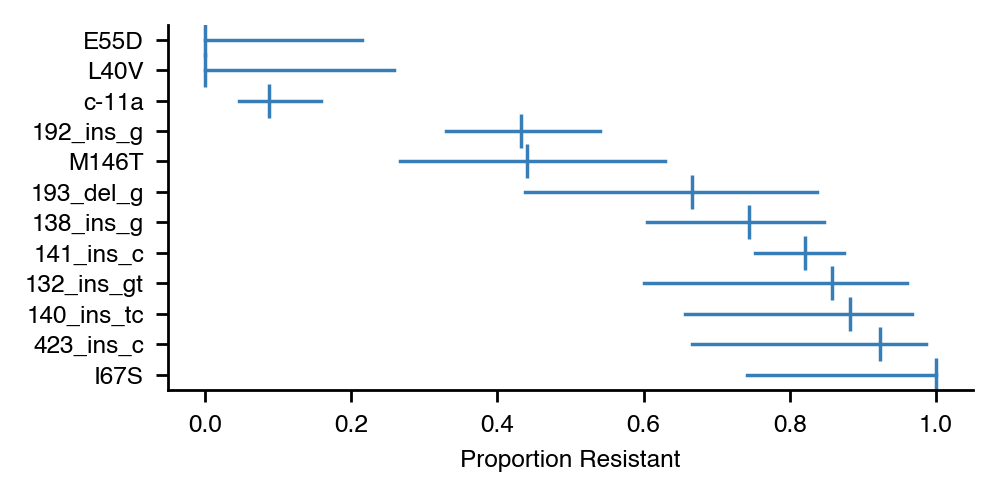

In [66]:
#remove mmpl5 and mmpS5 for clarity (under the assumption their variants are benign)
_cat_mutations = cat_mutations[cat_mutations.GENE.isin(['Rv0678', 'pepQ', 'atpE'])]

# build catalogue without phenotyping
catalogue = BuildCatalogue(
    samples=samples,
    mutations=_cat_mutations,
    FRS=0.1,
    test=None,
    record_ids=True
).return_catalogue()

catalogue = {k: v for k, v in catalogue.items() if 'seeded' not in v['evid']}

rv0678_cat = {k.split('@')[1]:v for k,v in catalogue.items() if k.split('@')[0] == 'Rv0678'}

trimmed_rv0678 = {}
for k,v in rv0678_cat.items():
    if v['evid'][0]['contingency'][0][0] + v['evid'][0]['contingency'][0][1] > 10:
        trimmed_rv0678[k] = v

figures, axes = utils.plot_catalogue_proportions(trimmed_rv0678, figsize=(4, 2), order=True) 


For the high frequency mutations, there is considerable phenotype heterogenity, particularly for 192_ins_g.Biologcailly, this is very hard to understand. A loss of function frame shift mutation half way down the gene only confers resistance in half the samples it is present in...

In [48]:
print ('Proportion of samples containing  192_ins_g that are resistant:', len(all[(all.MUTATION=='Rv0678@192_ins_g')&(all.PHENOTYPE=='R')])/len(all[all.MUTATION=='Rv0678@192_ins_g'])) 
print ('Proportion of samples containing  only 192_ins_g that are resistant:', rv0678_cat['192_ins_g']['evid'][0]['proportion'], '±',  rv0678_cat['192_ins_g']['evid'][0]['proportion'] - rv0678_cat['192_ins_g']['evid'][0]['confidence'][0])


Proportion of samples containing  192_ins_g that are resistant: 0.5089285714285714
Proportion of samples containing  only 192_ins_g that are resistant: 0.43209876543209874 ± 0.10237799401868797


In [49]:
common_indels = ['Rv0678@141_ins_c', 'Rv0678@192_ins_g', 'Rv0678@138_ins_g']
R = all[all.PHENOTYPE=='R']
print('proportion of (all) resistant samples containing these indels', len(R[R.MUTATION.isin(common_indels)])/R.UNIQUEID.nunique())

proportion of (all) resistant samples containing these indels 0.34988452655889146


One could hypothesise that there is a relationship between position along the gene and effect on resistance for loss of function mutations - the further along the gene the loss of function is, the less it will abrogate function (although the above proportion suggests this isn't the case)...

lofs - Pearson Correlation Coefficient: 0.07479247921026252, P-value: 0.5265222790817096


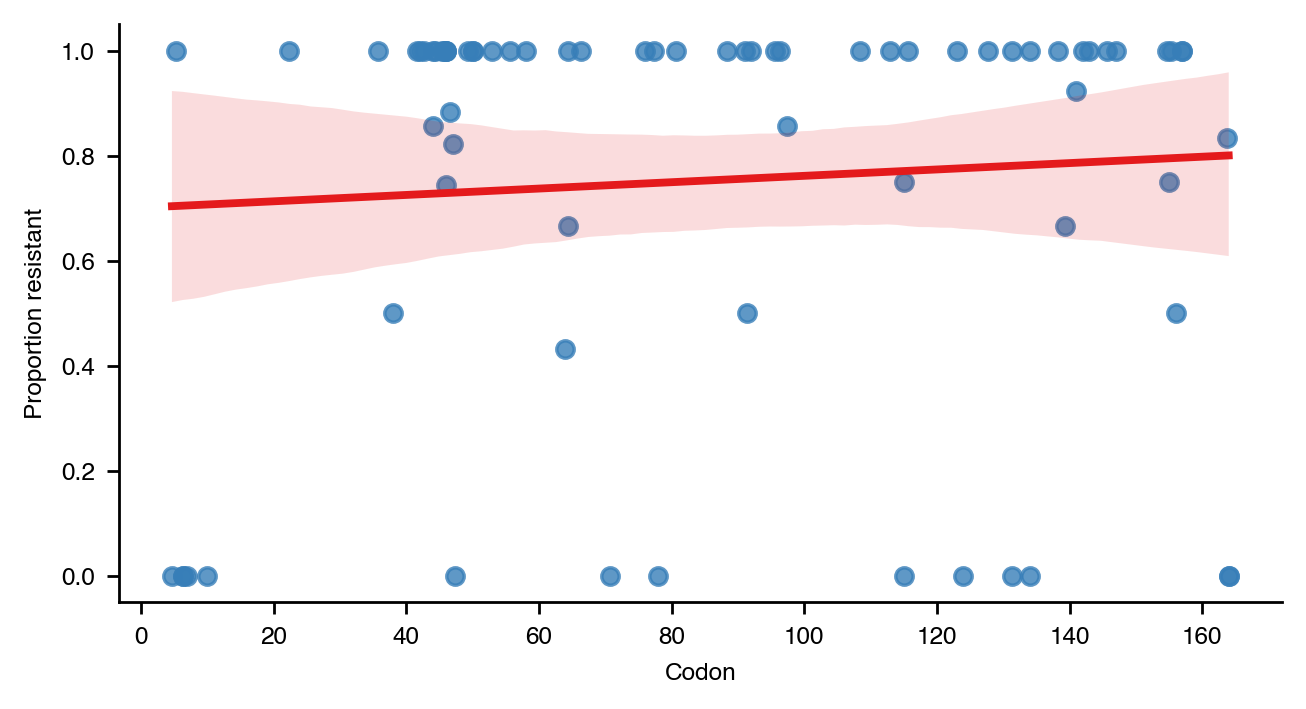

In [50]:
# Functon to pull position from GARC grammar
def extract_position(key):
    position = "".join(filter(str.isdigit, key.split("_")[0]))   
    position = int(position)
    if 'ins' in key or 'del' in key:
        return position / 3
    else:
        return position

# Function to determine if mutation is an SNP or lof
def mutation_type(key):
    if 'ins' in key or 'del' in key:
        return 'indel'
    elif '!' in key:
        return 'stop'
    else:
        return 'snp'

# Extract positions, proportions, and mutation types
positions = []
proportions = []
mutation_types = []
mutation = []
ci = []

for key, value in rv0678_cat.items():
    try:
        position = extract_position(key)
    except:
        continue
    proportion = value['evid'][0]['proportion']
    m_type = mutation_type(key)
    positions.append(position)
    proportions.append(proportion)
    mutation_types.append(m_type)
    mutation.append(key)

# Create a DataFrame for easy handling
df = pd.DataFrame({'Mutation': mutation, 'Position': positions, 'Proportion': proportions, 'Type': mutation_types})

df_lof = df[df['Type'].isin(['indel', 'stop'])]

# Calculate the Pearson correlation coefficient for lofs
pcc_lof, p_value_lof = pearsonr(df_lof['Position'], df_lof['Proportion'])
print(f"lofs - Pearson Correlation Coefficient: {pcc_lof}, P-value: {p_value_lof}")

# Plot the results using sns.regplot for lofs
fig, axis = plt.subplots(figsize=(6, 3))
axis = sns.regplot(x='Position', y='Proportion', data=df_lof, scatter_kws={'s':25, 'color':'#377eb8'}, line_kws={'color':'#e41a1c'}, ci=95, ax=axis)
plt.xlabel('Codon')
plt.ylabel('Proportion resistant')
# plt.title('Loss of function mutations in Rv0678 occur along the entire gene')
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
for item in [ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels():
    item.set_fontsize(9)
axis.grid(False)
fig.savefig('pdf/supplement/fig-lof-correlation.pdf', bbox_inches='tight',transparent=True)
plt.show()

Plotting position vs propotion of resistance for samples containing solo loss of functions (irrespective of frequency) suggests no correlation. Although the mean proportion of resistance is fairly high (~70-80%), the fact its not higher (close to 1, for example) suggests either error or a biological mechanism is misssing.

Oren and Jihand have observed framehsift mutations that kick the gene into a reading frame that is similar to the WT..... need to explore this further, and see if it accounts for heterogeneity - these will cause false positives if relevant.

### Evidence plots for all genes

We should examine proportions of resistance for all candidate genes and solo mutations:

In [51]:
#include mmpL5 and mmpS5 for evidence figures

# build catalogue without phenotyping
# assume homogenous S = Susceptible for purporses of recording max variants
catalogue = BuildCatalogue(
    samples=samples,
    mutations=cat_mutations,
    FRS=0.1,
    seed=['mmpL5@T794I', 'mmpL5@I948V', 'mmpL5@D767N'],
    test=None,
    record_ids=True
).return_catalogue()
#removed seeded mutations
catalogue = {k: v for k, v in catalogue.items() if 'seeded' not in v['evid']}

catalogue = dict(sorted(catalogue.items(), key=lambda item: extract_position(item[0]), reverse=True))
#seperate mutations by gene
rv0678_cat = {k.split('@')[1]:v for k,v in catalogue.items() if k.split('@')[0] == 'Rv0678'}
pepQ_cat = {k.split('@')[1]:v for k,v in catalogue.items() if k.split('@')[0] == 'pepQ'}
atpE_cat = {k.split('@')[1]:v for k,v in catalogue.items() if k.split('@')[0] == 'atpE'}
mmpS5_cat = {k.split('@')[1]:v for k,v in catalogue.items() if k.split('@')[0] == 'mmpS5'}
mmpL5_cat = {k.split('@')[1]:v for k,v in catalogue.items() if k.split('@')[0] == 'mmpL5'}

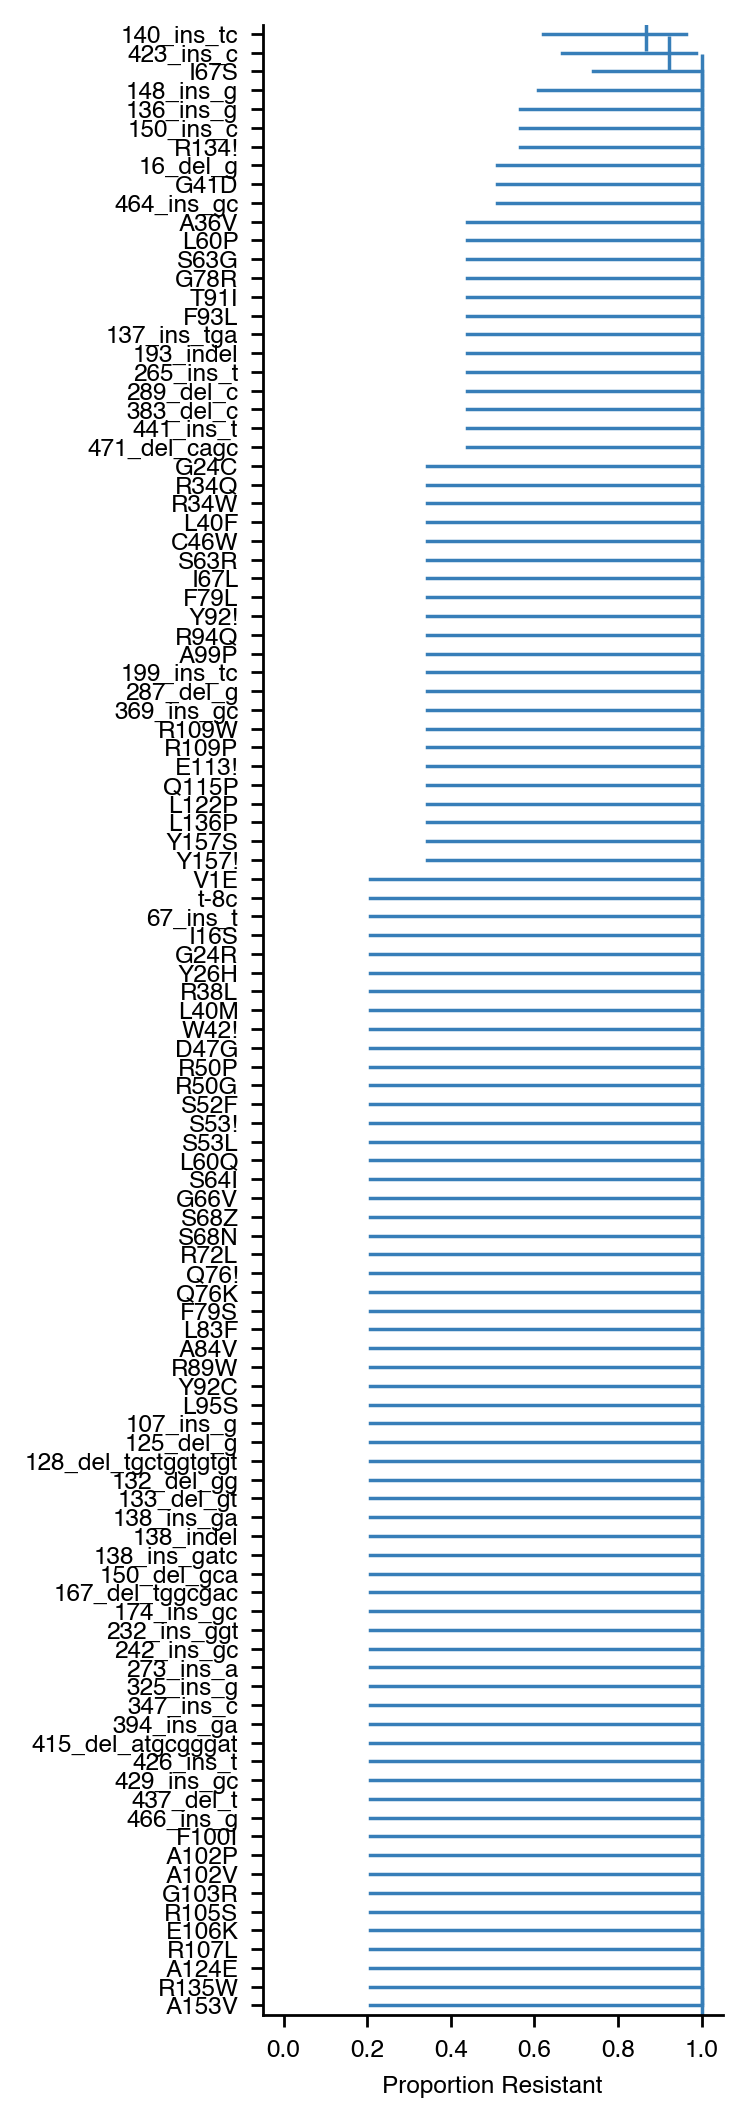

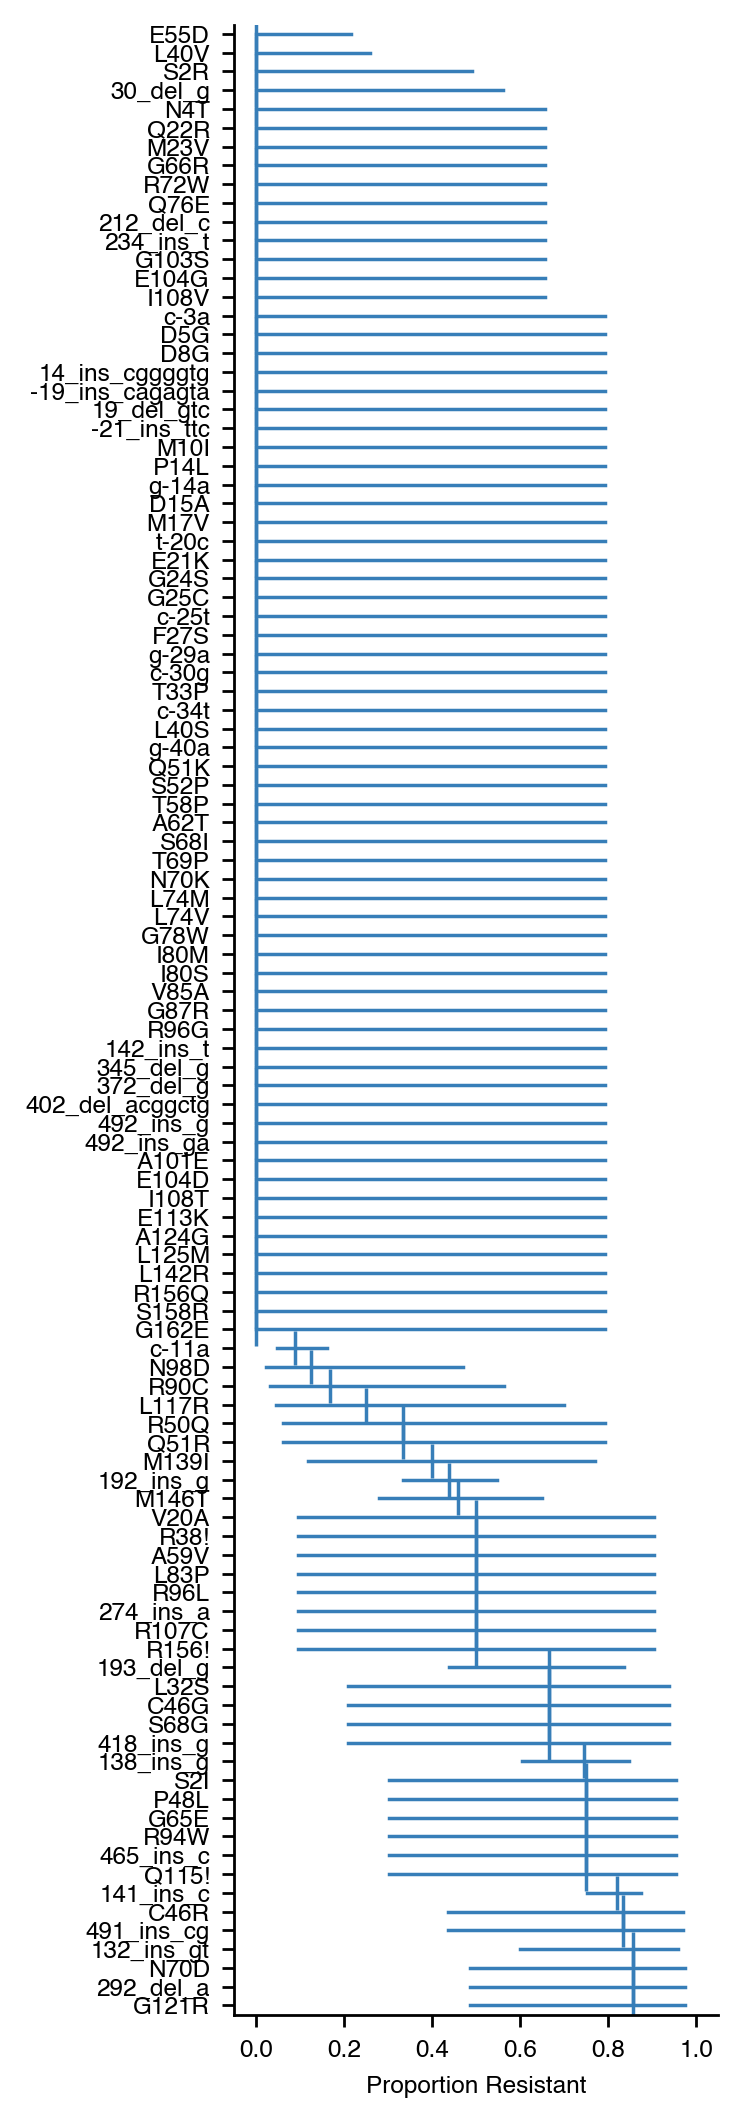

In [58]:
figures, axis = utils.plot_catalogue_proportions(rv0678_cat, figsize=(3, 8.5), order=True)
counter=0
for (i,j) in zip(figures,axis):
    i.savefig('pdf/supplement/fig-evidence-Rv0678-'+str(counter)+'.pdf', transparent=True, bbox_inches='tight')
    counter+=1

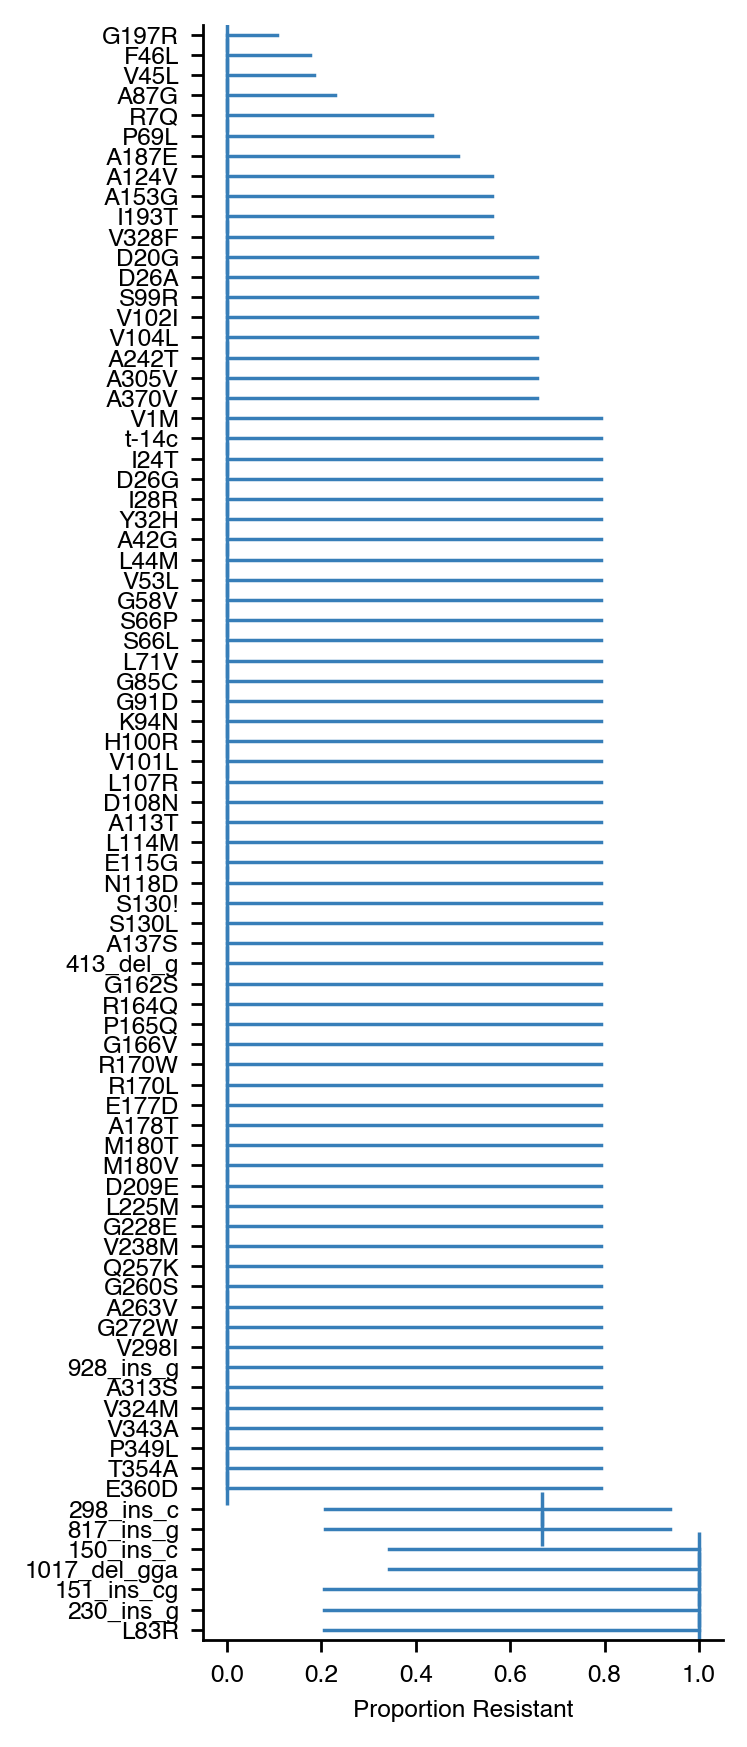

In [63]:
figures, axes = utils.plot_catalogue_proportions(pepQ_cat, figsize=(3, 7), order=True)
counter=0
for (i,j) in zip(figures,axes):
    i.savefig('pdf/supplement/fig-evidence-pepQ-'+str(counter)+'.pdf', transparent=True, bbox_inches='tight')
    counter+=1

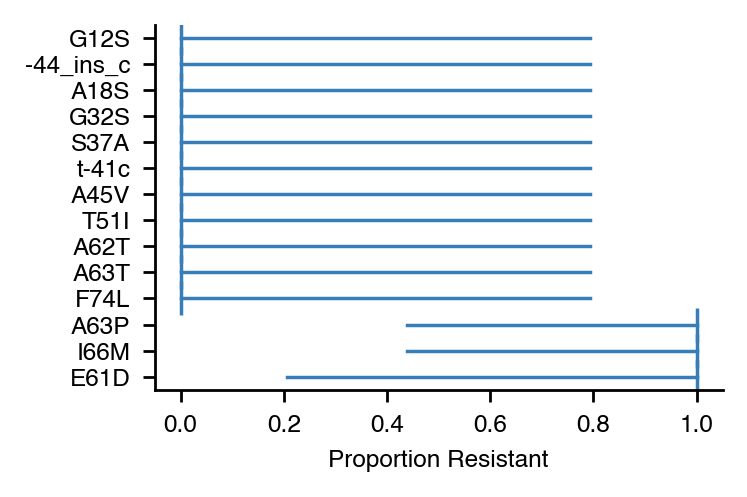

In [65]:
figures, axes =  utils.plot_catalogue_proportions(atpE_cat, figsize=(3,2), order=True)
counter=0
for (i,j) in zip(figures,axes):
    i.savefig('pdf/supplement/fig-evidence-atpE-'+str(counter)+'.pdf', transparent=True, bbox_inches='tight')
    counter+=1

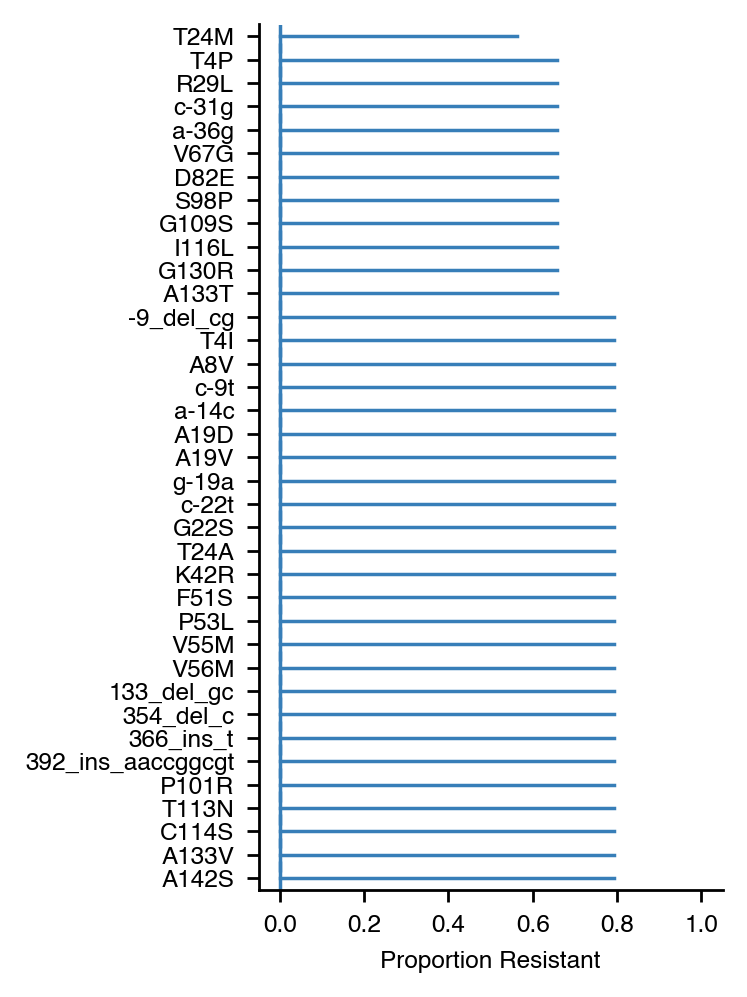

In [68]:
figures, axes = utils.plot_catalogue_proportions(mmpS5_cat, figsize=(3, 4), order=True)
counter=0
for (i,j) in zip(figures,axes):
    i.savefig('pdf/supplement/fig-evidence-mmpS5-'+str(counter)+'.pdf', transparent=True, bbox_inches='tight')
    counter+=1

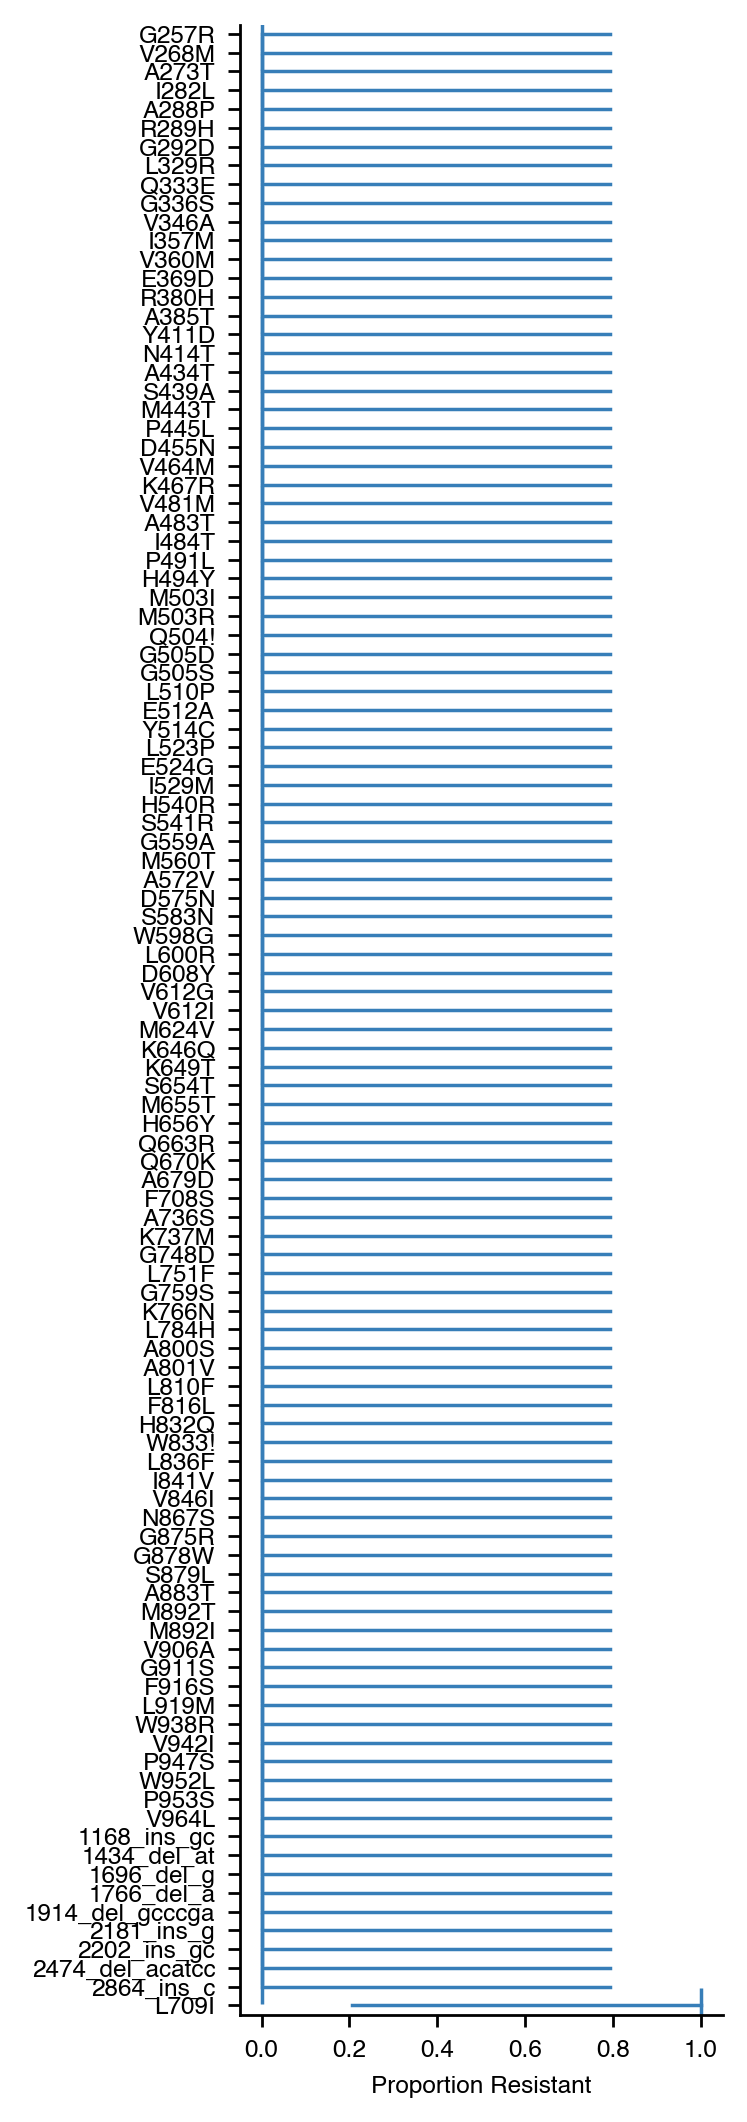

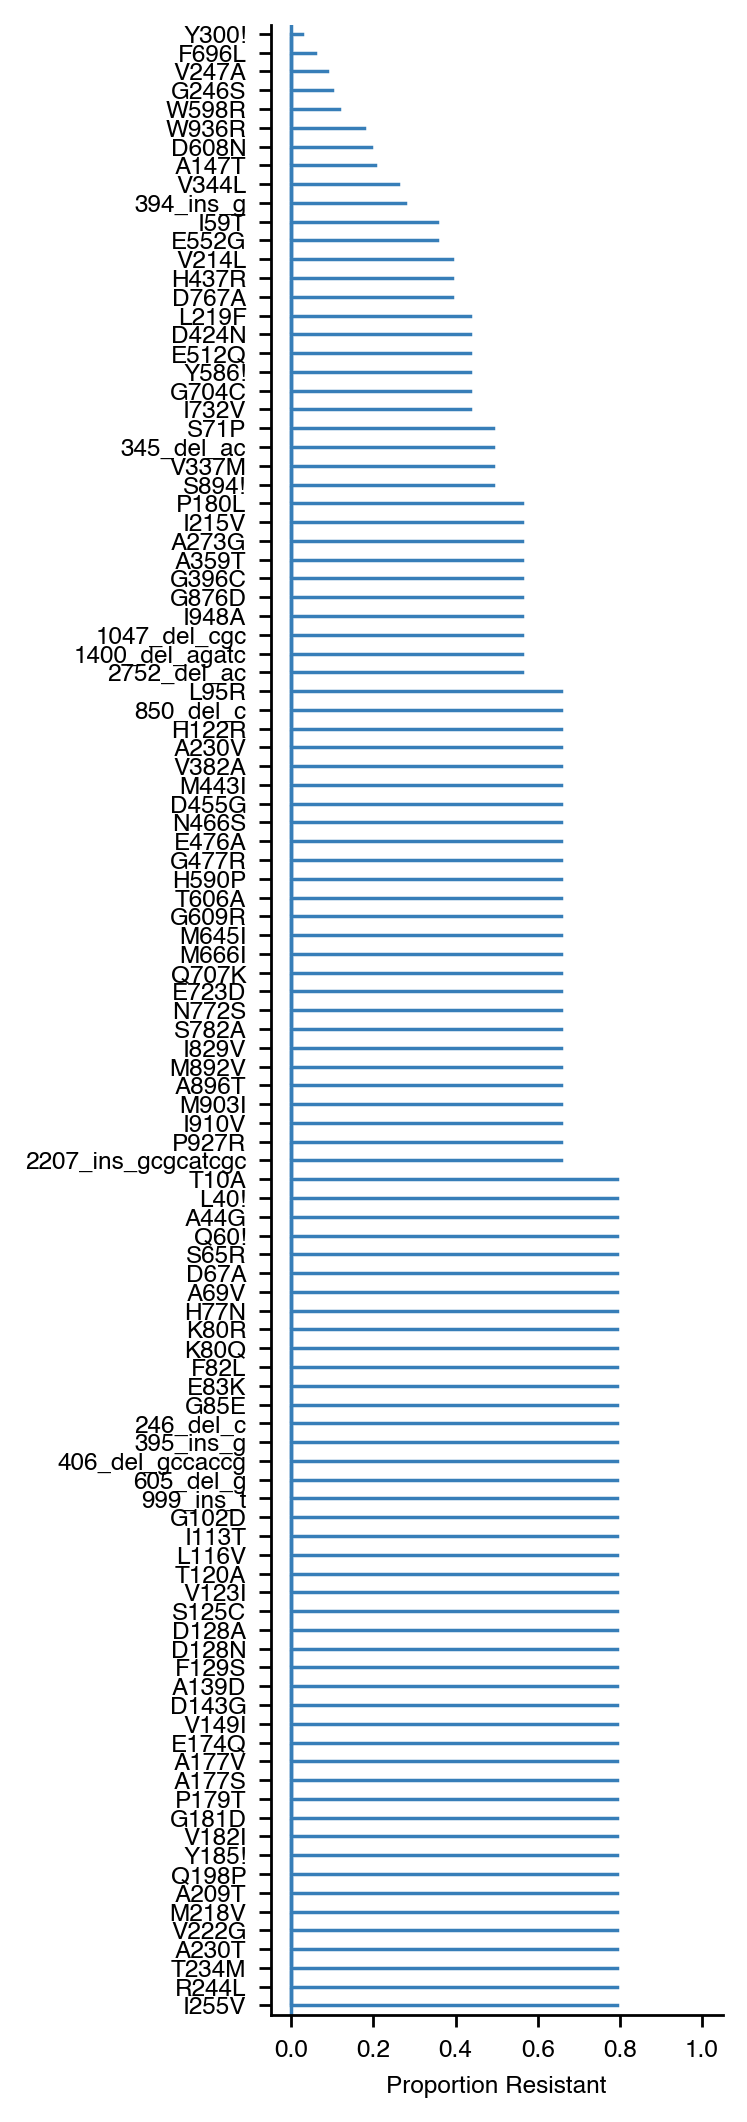

In [69]:
figures, axes = utils.plot_catalogue_proportions(mmpL5_cat, figsize=(3, 8.5), order=True)
counter=0
for (i,j) in zip(figures,axes):
    i.savefig('pdf/supplement/fig-evidence-mmpL5-'+str(counter)+'.pdf', transparent=True, bbox_inches='tight')
    counter+=1

#### Rv0678-mmpL5 epistasis

Aside from phylogenetic mutations (which have been removed), a stop codon at position 300 in mmpL5 is the most frequenlty observed mutation in the gene.

There is evidence there is an epistatic link between loss of function mutations in mmpL5 and those in Rv0678 - samples containing both are susceptinble as the efflux pump function is abrogated [5]. 

We can therefore determine how many of the Rv0678 susceptible variants are explained by co-existing with an mmpL5 LOF - in particular, Y300! (although we already know this number will be small if not zero, as the large proportions plot above excludes mutations that co-occur in combination with others in the candidate genes, and there is still the same amout of heteroresistance as solos only):

In [100]:
all = all[~all.MUTATION.isna()]
all['type'] = [mutation_type(mut) for mut in all.MUTATION]

# Filter for loss of function mutations in mmpL5 (STOP or INDEL)
mmpL5_loss_of_function = all[(all['GENE'] == 'mmpL5') & (all['type'].isin(['STOP', 'INDEL']))]

# Filter for Rv0678 gene
Rv0678_gene = all[all['GENE'] == 'Rv0678']

# Find IDs that are in both filtered dataframes
shared = set(mmpL5_loss_of_function['UNIQUEID']).intersection(set(Rv0678_gene['UNIQUEID']))

# Filter original dataframe for those IDs
print ('Number of samples (in whole dataset) containing LOF in mmpL5 and a mutation in Rv0678:', all[all['UNIQUEID'].isin(shared)].UNIQUEID.nunique())

Number of samples (in whole dataset) containing LOF in mmpL5 and a mutation in Rv0678: 0


As expected, lof mutations in mmpL5 do not account for the heteroresistance observed in our dataset - in fact there are no samples containing both lof in mmpL5 and any mutation in Rv0678.

Therefore, our heterogeneity must be coming from somewhere else... 

### Non-bimodal MIC distributions

Elevated MICs for BDQ variants have been reported, rather than clear bimodal distributions

We can investigate our MIC distributions, however there are 2 phenotyping methods (ukmyc plates vs mgit) with different MIC ranges and ECOFFs - therefore, need to plot seperately.

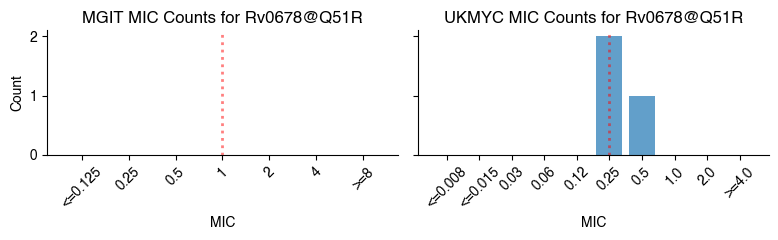

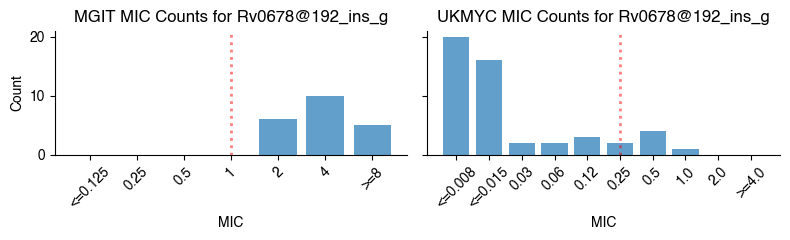

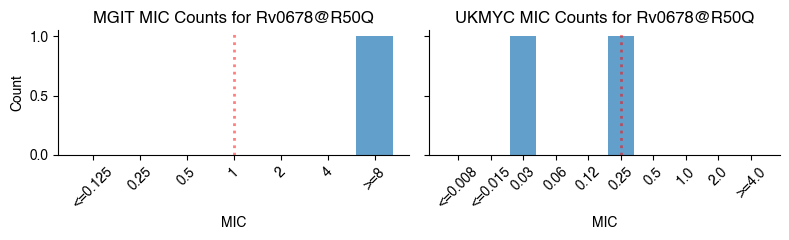

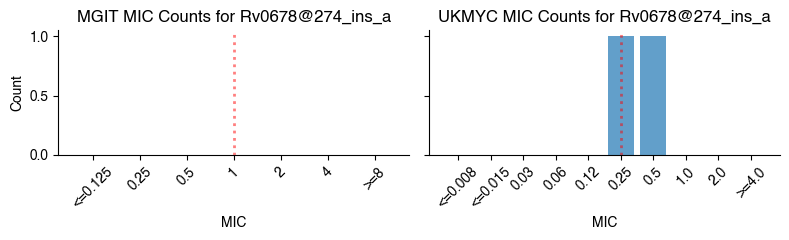

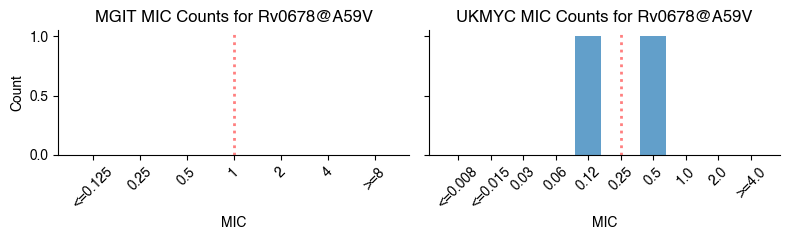

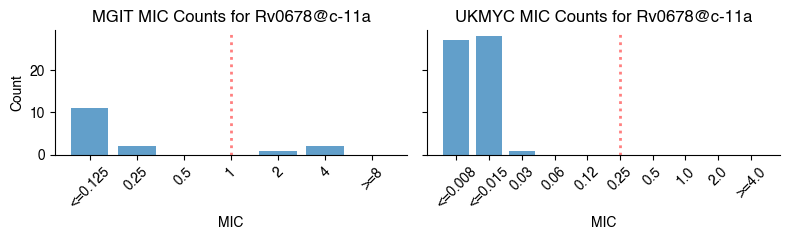

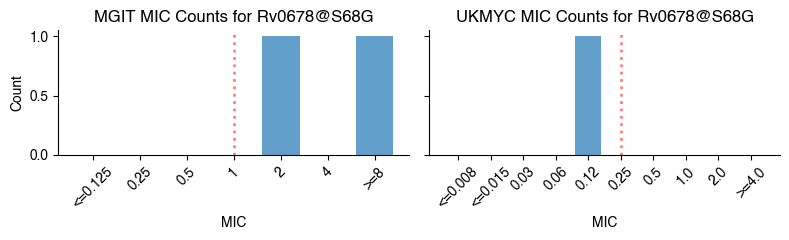

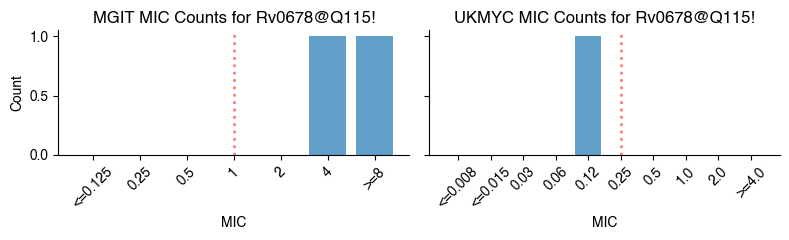

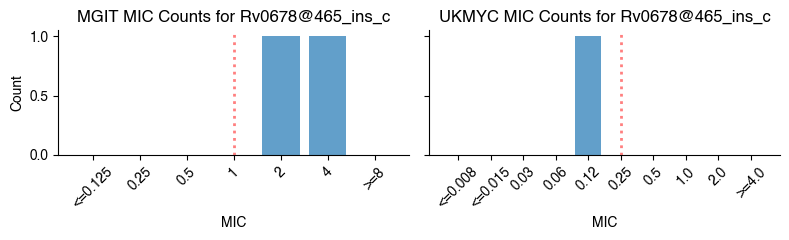

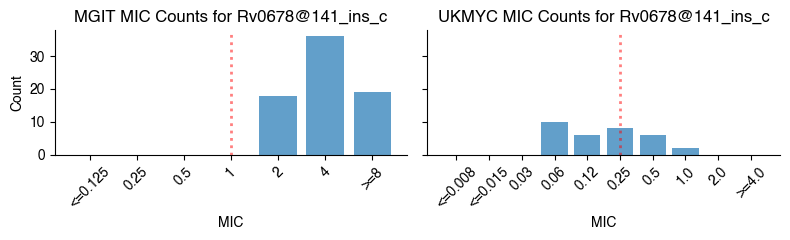

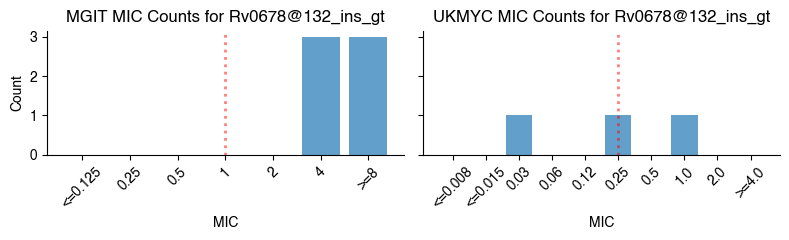

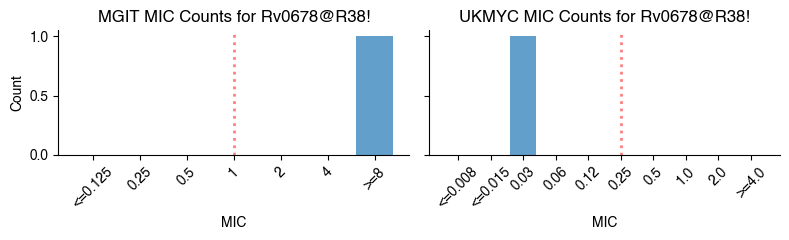

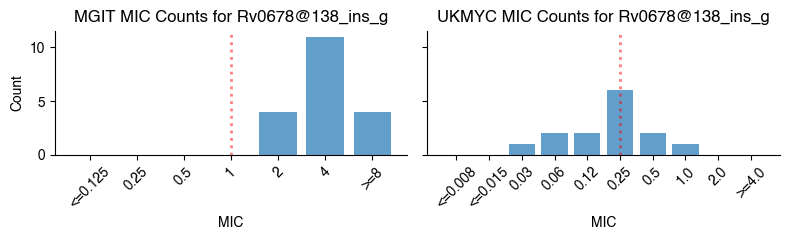

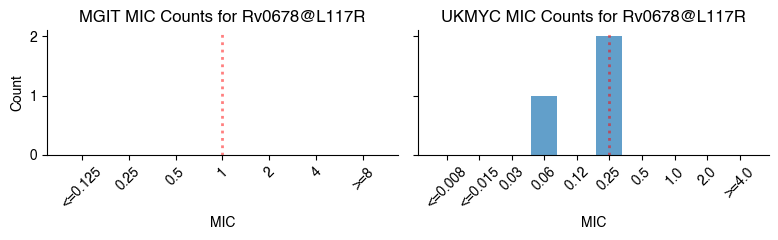

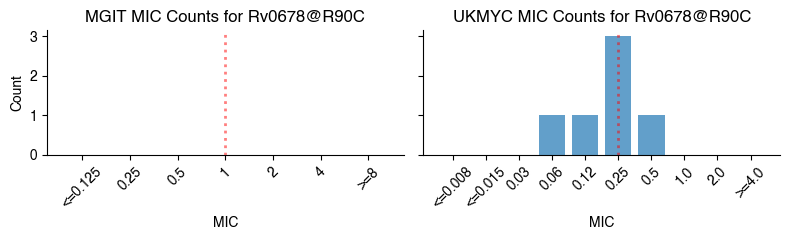

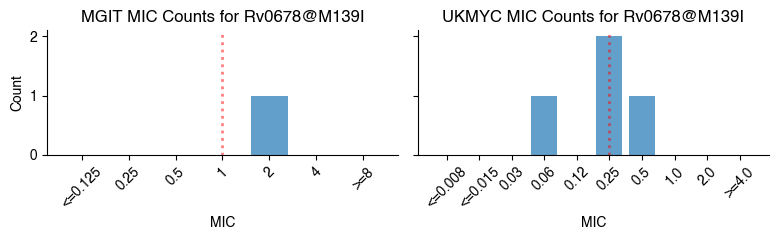

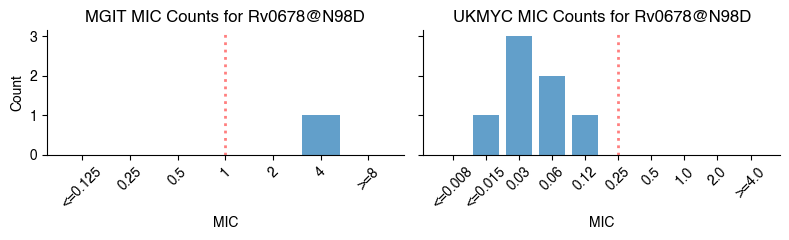

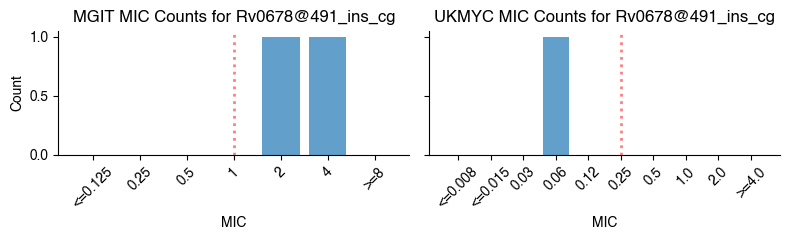

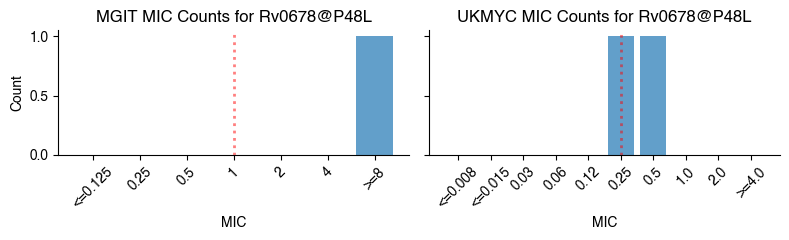

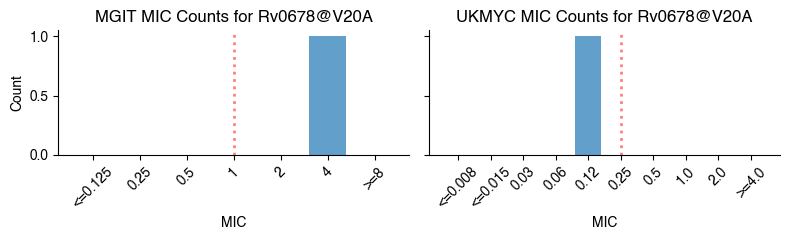

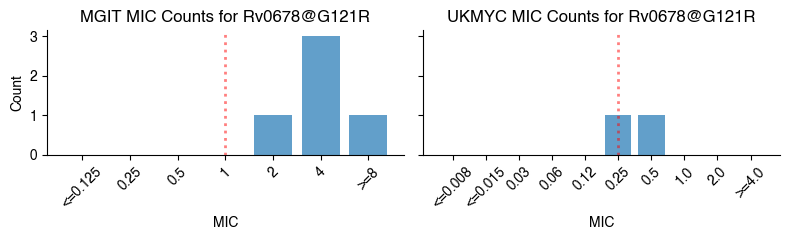

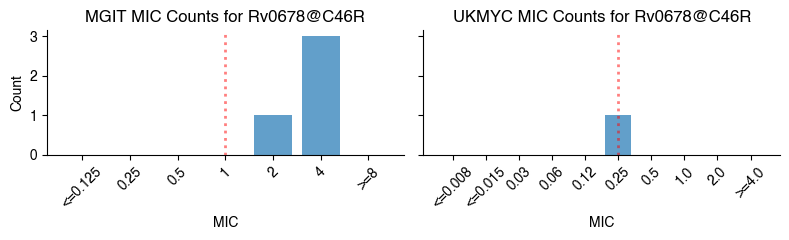

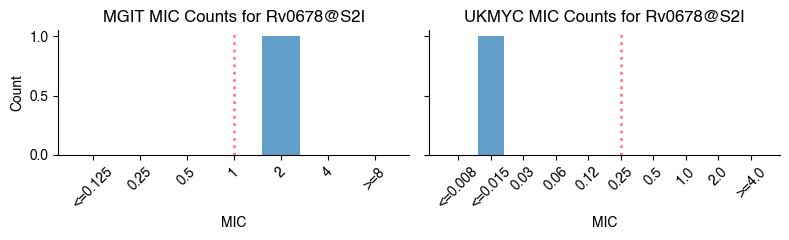

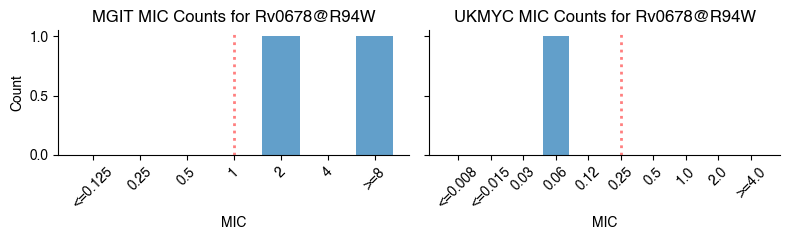

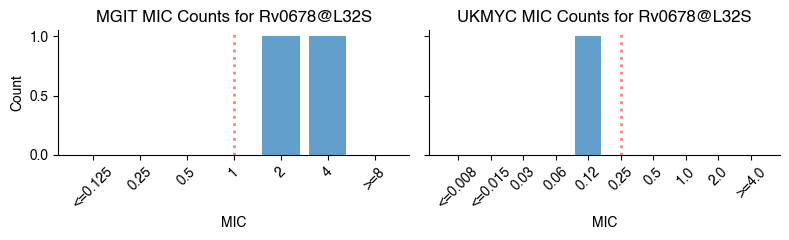

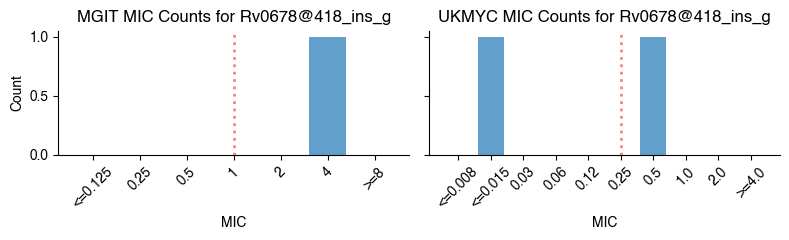

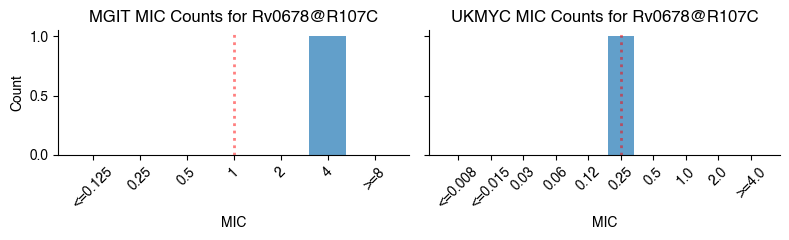

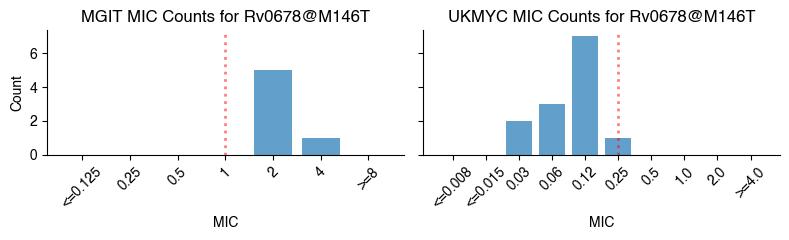

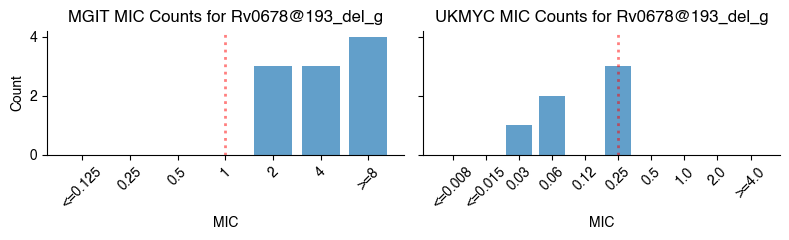

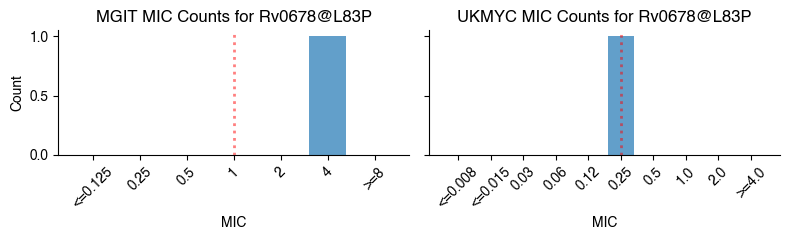

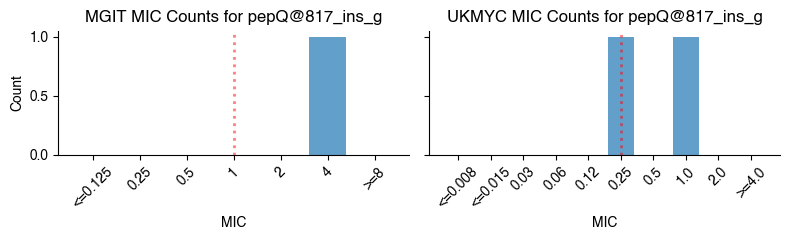

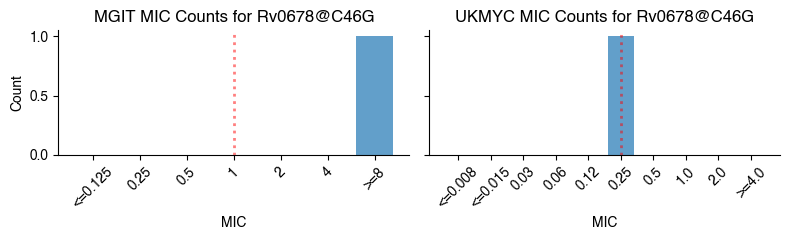

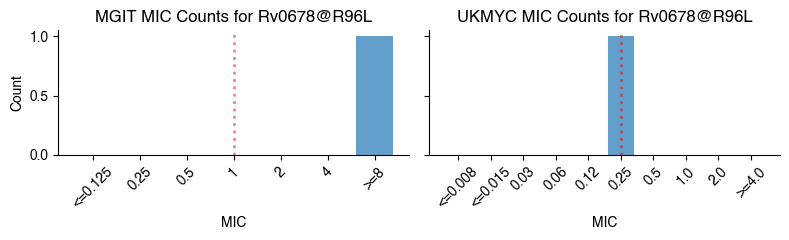

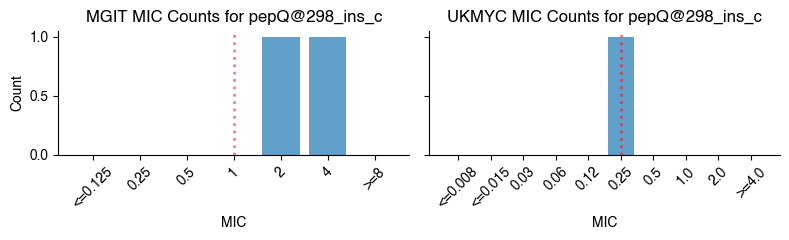

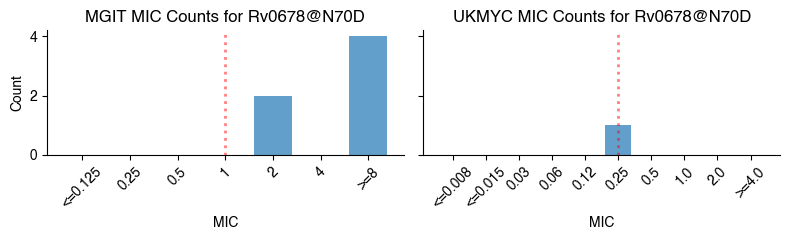

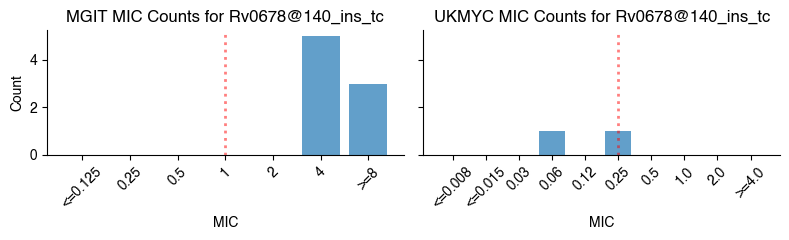

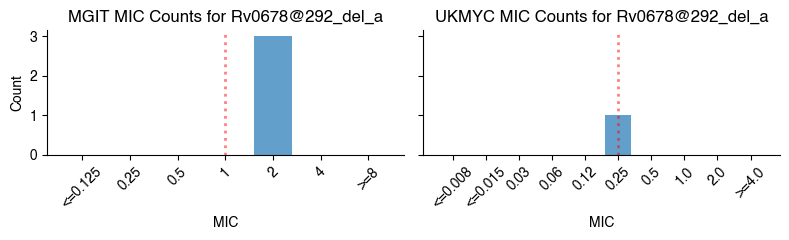

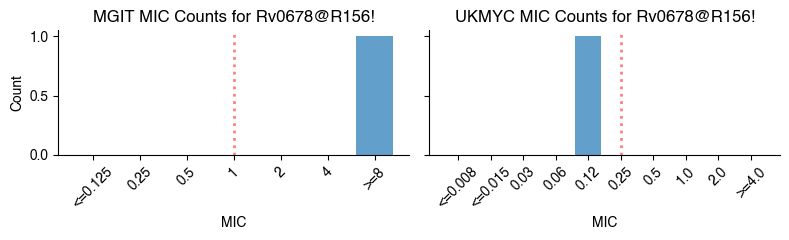

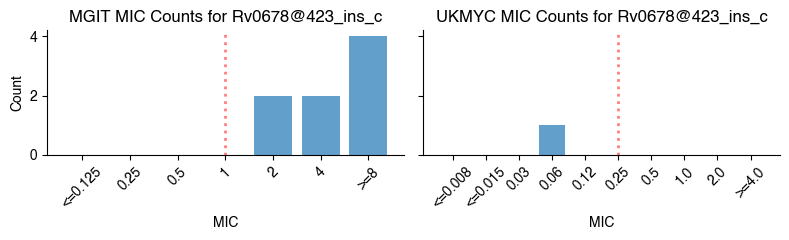

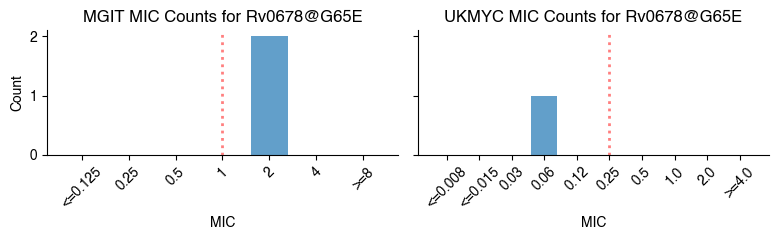

In [102]:
catalogue_heterogenous = {
    k: v
    for k, v in catalogue.items()
    if (v["evid"][0]["contingency"][0][0]  > 0) and (v["evid"][0]["contingency"][0][1] > 0)
}

non_zero, ids = {}, []
for k, v in catalogue_heterogenous.items():
    evid = v['evid'][0]
    non_zero[k] = {'R':evid['contingency'][0][0], 'S': evid['contingency'][0][1]}
    ids+=evid['ids']

#different phenotyping methods - therefore need different sets of plots. For simplificaion, UKYMC5 and UKYMC6 plates have been combined
joined = pd.merge(samples, mutations, how='left', on=['UNIQUEID'])
joined = joined[(joined.MUTATION.isin(non_zero.keys())) & (joined.UNIQUEID.isin(ids))]

# Define the mic mapping dictionary
nmics = {
    '<=0.008': 0.008,
    '0.12':0.12,
    '0.06':0.06,
    '<=0.015': 0.015,
    '0.03':0.03,
    '1.0':1.0,
    '>1':1.0,
    '0.015':0.015,
    '2': 2.0,
    '0.5': 0.5,
    '<=0.125': 0.125,
    '4': 4.0,
    '8': 8.0,
    '>8': 8.0, 
    '1': 1.0,
    '>2': 2.0, 
    '0.25': 0.25
}

# Map the METHOD_MIC values to numeric
joined['NUMERIC_MIC'] = joined['METHOD_MIC'].apply(lambda mic: nmics[mic] if mic in nmics else np.nan)

# Define consistent bins for the histograms
nicd_bin_labels = ['<=0.125', '0.25', '0.5', '1', '2', '4', '>=8']
nicd_bins = [ 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, np.inf]  # Adjust to include all ranges

other_bin_labels = ['<=0.008', '<=0.015', '0.03', '0.06', '0.12', '0.25', '0.5', '1.0', '2.0', '>=4.0']
other_bins = [0.008, 0.015, 0.03, 0.06, 0.12, 0.25, 0.5, 1.0, 2.0, 4.0, np.inf]

muts = joined['MUTATION'].unique()
#plot nicd and plate mics side by side for each relevant mutations
for mutation in muts:
    subset_nicd = joined[(joined['MUTATION'] == mutation) & (joined['SOURCE'] == 'NICD')]
    subset_not_nicd = joined[(joined['MUTATION'] == mutation) & (joined['SOURCE'] != 'NICD')]
    
    counts_nicd, _ = np.histogram(subset_nicd['NUMERIC_MIC'].dropna(), bins=nicd_bins)
    counts_not_nicd, _ = np.histogram(subset_not_nicd['NUMERIC_MIC'].dropna(), bins=other_bins)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 2.5), sharey=True)
    
    axes[0].bar(nicd_bin_labels, counts_nicd, edgecolor=None, alpha=0.7)
    axes[0].set_title(f'MGIT MIC Counts for {mutation}')
    axes[0].set_xlabel('MIC')
    axes[0].set_ylabel('Count')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].axvline(x=3, color='red', linestyle='dotted', linewidth=2, alpha=0.5)

    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)
    
    axes[1].bar(other_bin_labels, counts_not_nicd, edgecolor=None, alpha=0.7)
    axes[1].set_title(f'UKMYC MIC Counts for {mutation}')
    axes[1].set_xlabel('MIC')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].axvline(x=5, color='red', linestyle='dotted', linewidth=2, alpha=0.5)

    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)

    
    plt.tight_layout()
    plt.show()
 

The majority of hetoresistance actually derives from phenotype disagreements between the old CRypTIC UKMYC plates and the new NICD MGIT samples - largely, the plates' MIC distributions are below or over the ECOFF, whereas MGIT distributions are above. 

The 138_ins_g and 141_ins_c plates have elevated MICs, which is consistent with observations in other studies (citation needed). This perhaps suggests the ecoff breakpoint is positioned too high?

However, 192_ins_g is particularly concerning - the vast majority of plate samples have minimum MICs, which is hard to rationalise. 


I would argue we don't have enough data to draw clear MIC distributions, however, should these mirror ethamubtol's normal distributions, it raises the question of whether binary labels for BDQ is suitable. If they are not normally distributed, it would suggest error (mislabelling) or there is a missing candidate gene

### Tertiary classification system

As discussed, the Walker2015 algorithm works on the assumption of high penentrance for resistant variants. 

In practise (ie, once the MICs labels are binarised), our resistant variants do not have high penentrance - the underlying prior breaks down.

Therefore, the second requirement of our algorithm can be specified: it must be able to report mutations for which there is high heteroresistance or unclear bimodality.

We  need a statistical test (rather than a heursitic) that can explicitly return a third (and maybe even a fourth) label that captures mutations for which we have too little data (due to low evidence for most variants, discusssed above) and can capture highly heteroresistant variants.

R, U, S     or      R, I, U, S

The test should be 2-tailed. 

A 1-tailed test, would look for a statistically greater proportion of resistance than background, and variants whose null hypotheses are accepted are classified susceptible, regardless of statistical power. This would only provide a binary system.

A 2-tailed test, on the other hand, would 'actively classify' resistant and susceptible variants - the proportion of susceptiblity must be significantly less than background for a susceptible classification. Variants whose null hypotheses are accepted would be deemed 'Unknown/Unclassified'.

## Hypothesis testing against a calculated background

Ideally, we would run a binomial hypothesis test against a meaningful reference resistance rate that reflects:
 - sampling error
 - labelling error
 - unexplainable resistance (ie other genes or missing mechanisms)

We could then implement a Fisher's exact test to test against the background rate, similarly to the confidence grading step used in WHOv2 [3] (look at the WHOv2 method - ./imgs/manuscript_2/WHOv2_workflow.png)

We can calculate a background rate for each mutation as the proprotion of resistance in the absence of that mutation or any mutations not yet classified as benign.

Note, this is different to WHOv2, which just defines background as proportion of resistance in the absence of that mutation - which we argue is a little meaningless as it leaks in resistance rates from potentially resistance inducing variants. 

We can calculate the background rates from the contingency tables of variants in isolation extracted by catomatic:


In [103]:
backgrounds = []
for k, v in catalogue.items():
    backgrounds.append(v['evid'][0]['contingency'][1][0]/(v['evid'][0]['contingency'][1][0]+v['evid'][0]['contingency'][1][1]))

print ('maximum calculated background rates for solo mutations:', np.max(backgrounds))
print ('mean backround rate:', np.mean(backgrounds))
print ('background rate std:', np.std(backgrounds))

maximum calculated background rates for solo mutations: 0.013736545361353152
mean backround rate: 0.013293432956863898
background rate std: 0.000624210984684683


A background rate of ~1.5% is very small.

In reality our calculated backgrounds cannot be interpreted as we are combining 2 datasets. The first is much larger and was collected when BDQ was novel and clinical use was limited - its proportion of resistance is 0.78%. The second is much smaller was collected under a heavy sampling bias protocol, where BDQ resistance was sought after - 67% resistant. Therefore, the vast majority of resistant samples are contributed by the second dataset, but the first dataset swamps the background rate toward susceptible. 

It is therefore unsurprising that we see such low values.

A consequence of this extreme bias is that any phenotype heterogeneity will be called resistant, as the proportion of resistance has to only be significantly greater than 2%...

# Hypothesis testing against a fixed background

It therefore perhaps makes sense to test against a defined, fixed background rate, and use a Binomial test.

For example, we can define a backgorund rate of 10%:


([<Figure size 600x400 with 1 Axes>], [<Axes: xlabel='proportion resistant'>])

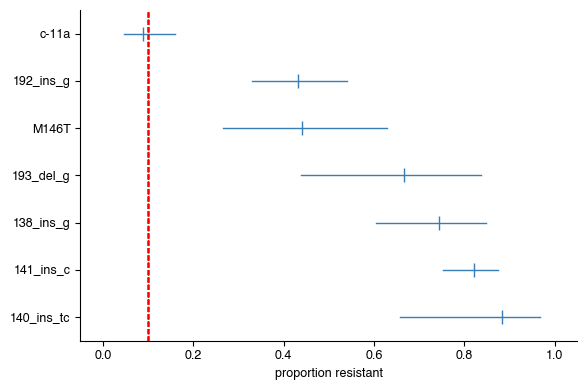

In [106]:
utils.plot_catalogue_proportions(trimmed_rv0678, figsize=(6, 4), order=True, background=0.1) 

And if we test catalogue performance using a 10% background:

In [116]:
#Run a 2-tailed Binomial Test
catalogue = BuildCatalogue(
    samples=samples,
    mutations=_cat_mutations,
    FRS=0.1,
    test='Binomial',
    background=0.1,
    tails='two',
    strict_unlock=True,
)

catalogue_dict = catalogue.return_catalogue()
catalogue_dict = {k: v for k, v in catalogue_dict.items() if 'seeded' not in v['evid']}

R = sum(1 for v in catalogue_dict.values() if v['pred'] == 'R')
S = sum(1 for v in catalogue_dict.values() if v['pred'] == 'S')
U = sum(1 for v in catalogue_dict.values() if v['pred'] == 'U')

print ('Resistant classification counts: \n\n', R)
print ('Susceptible classification counts: \n\n', S)
print ('Unclassified classification counts: \n\n', U)

catalogue.to_piezo("NC_000962.3", f"BDQ-FRS-75-2024.06", "1.1", "BDQ", piezo_wildcards, outfile='./catalogues/temp/binomial_2_tailed.csv')

Resistant classification counts: 

 71
Susceptibleb classification counts: 

 0
Unclassified classification counts: 

 242


This makes no assumption of the probability of conferred resistance for novel/low frequency variants, and honestly reports unclassifiable variants - which is in line with the amount of data available. As expected, all our susceptible classifications are now unclassified due to low sample nubmers.

[[  607   135   124]
 [  172 10370   459]]
Catalogue coverage of isolates: 0.9508721665121767
Sensitivity: 0.8180592991913747
Specificity: 0.9836843103775375


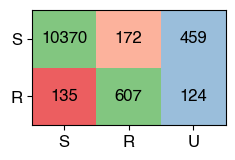

In [117]:
#make predictions to calculate sensitivity and coverage

#remove mmpL5 and mmpS5
all_ = pd.merge(samples, mutations[~mutations.GENE.isin(['mmpL5', 'mmpS5'])],  how='left', on='UNIQUEID')

cm, _cov, _sens, _spec, _FN_ids, _FP_ids = piezo_predict(all_ , './catalogues/temp/binomial_2_tailed.csv', "BDQ", Print=True, U_to_S=False)

df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S", "U"])

utils.plot_truthtables(df_cm)


Not totally unlike [1],the placement of the background implicitly upwegihts resistance over susceptiblity -  before calling a mutation benign, there must be considerable supporting evidence, which from a clinical standpoint will in theory help minimise the number of very major errors.

Because the approach is algorithmic, we can observe the effect on performance when varying the background rate:

In [118]:
results = []

for i in np.arange(0, 1, 0.05):
    # Build and save catalogue across background range
    catalogue_name = f"BDQ-BG-{int(i*100)}-2024.06"
    csv_path = f"./catalogues/temp/catalogue_BG_{int(i*100)}.csv"
    
    catalogue =  BuildCatalogue(samples, _cat_mutations, FRS=0.1, test='Binomial', tails='two', strict_unlock=True, background=i)
    catalogue.to_piezo("NC_000962.3", catalogue_name, "1.1", "BDQ", piezo_wildcards, outfile=f"./catalogues/temp/catalogue_BG_{int(i*100)}.csv")
    
    # Predict with catalogue at FRS 0.1
    cm, _cov, _sens, _spec, _FN_ids, _FP_ids = piezo_predict(
        all_, 
        csv_path, 
        "BDQ", 
        Print=False, 
        U_to_S=False
    )
    
    results.append((i, _sens * 100, _spec * 100, _cov * 100, _FN_ids))

# Create DataFrame
data = pd.DataFrame(results, columns=["Background", "Sensitivity", "Specificity", "Coverage", "FNs"])

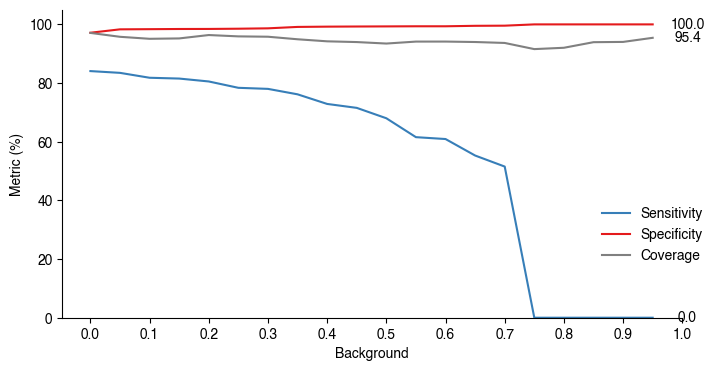

In [129]:
def background_vs_metric(df, cov=True):
    """
    Plots a comparison of performance metrics (Sensitivity, Specificity, and optionally Coverage)
    against a defined background rage.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the performance metrics with columns "Background",
                           "Sensitivity", "Specificity", and optionally "Coverage".
    cov (bool): If True, includes Coverage in the plot. Defaults to True.

    Returns:
    None

    """
    fig,axis = plt.subplots(figsize=(8, 4))

    # Plot Sensitivity and Specificity
    axis = sns.lineplot(x="Background", y="Sensitivity", data=df, label="Sensitivity", color="#377eb8", ax=axis)
    axis = sns.lineplot(x="Background", y="Specificity", data=df, label="Specificity", color="#e41a1c", ax=axis)

    # Plot Coverage if specified
    if cov:
        axis = sns.lineplot(
            x="Background", y="Coverage", data=df, label="Coverage", color="grey", ax=axis
        )

    # Set x and y ticks
    yticks = [0, 20, 40, 60, 80, 100]
    xticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    plt.yticks(yticks)
    plt.xticks(xticks)

    # Add labels and legend
    plt.xlabel("Background")
    plt.ylabel("Metric (%)")
    plt.legend(loc="best", frameon=False, bbox_to_anchor=(0.85, 0.40))

    # Annotate the start and end values
    for line in plt.gca().lines:
        x_data = line.get_xdata()
        y_data = line.get_ydata()
        start_value = y_data[0]
        final_value = y_data[-1]
        #plt.annotate(
        #    f"~{start_value:.2f}",
        #    (x_data[0], start_value),
        #    textcoords="offset points",
        #    xytext=(-23, -3),
        #    ha="center",
        #)
        plt.annotate(
            f"{final_value:.1f}",
            (x_data[-1], final_value),
            textcoords="offset points",
            xytext=(25, -3),
            ha="center",
        )


    # Despine and grid settings
    sns.despine(top=True, right=True)
    plt.grid(False)

    # Show plot
    plt.ylim(0, 105)
    plt.show()
    fig.savefig('pdf/supplement/fig-background-performance.pdf', bbox_inches='tight',transparent=True)

background_vs_metric(data[['Background', 'Sensitivity', 'Specificity', 'Coverage']], cov=True)

Owing to the imbalance of resistant and susceptible samples, dropping the background to a minimum boosts sensitivity with very little effect on specificity. As background increases, fewer variants are classified resistant, so sensitivity drops.

Where the background is placed is a philiosphical question, driven by clinical application. 10% is a fairly conservative threshold, and is roughly within range of plausible error rates. Again, should one feel differently, the background can easily be dialled up or down and the catalogues regenerated.



However, at a background of 10%, it is curious we still have 135 false negatives - the catalogue contains no susceptible variants, so susceptible predictions can only be made for samples with wild type candidiates under this regimen....

In [130]:
all.reset_index(inplace=True)
all[all.UNIQUEID.isin(_FN_ids)].MUTATION.value_counts()

MUTATION
mmpL5@I948V          387
mmpL5@T794I          259
Rv0678@141_ins_c     136
mmpL5@D767N           75
Rv0678@138_ins_g      41
Rv0678@192_ins_g      39
mmpL5@P355P           21
Rv0678@132_ins_gt     17
Rv0678@c-11a          16
Rv0678@M146T          11
mmpL5@L963L            5
Rv0678@P48L            4
Rv0678@R94W            3
Rv0678@M139I           2
Rv0678@V20V            2
Rv0678@I80S            2
Rv0678@L114R           1
mmpL5@V247A            1
Rv0678@N98D            1
Rv0678@R50Q            1
mmpL5@L709I            1
Rv0678@R90C            1
mmpS5@N68N             1
Rv0678@Q51R            1
atpE@E61D              1
Rv0678@274_ins_a       1
mmpL5@A730Z            1
mmpL5@A733Z            1
mmpL5@A736D            1
mmpL5@A755T            1
mmpL5@G724G            1
mmpL5@G753G            1
mmpL5@K737Z            1
mmpL5@L751L            1
mmpL5@L758L            1
mmpL5@M727Z            1
mmpL5@Q729Z            1
mmpL5@S721N            1
mmpL5@S754S            1
mmpL5@T740Z     

The false negative samples almost exclusively contain synonymous mutations or I948V, T794I, and D767N in mmpL5 - these are phylogenetic and probably susceptible [5]. This would suggest mislabelling for those samples or potential candidate genes are missing...

# Conclusion

In summary, we argue there is an issue of timing with regard to how long the drug has been administerd, and that methods to build catalogues must be tailored to amount of data available, and to the shapes of MIC distributions, as these dictate the validity of underlying assumptions and priors. The idea of one method fits all is outdated, and as long as each method used to build catalogues is reproducible, simple, and well-documented there is no reason to not tailor them.

Our chosen appraoch is a 2-tailed binomial test of resistant proportions against an arbitrary 10% background rate. This allows us to catalogue ~70 variants in Rv0678, pepQ, and atpE (exact number depends on catomatic paramtisation - final catalogue shown in `results.ipynb`)

We recognise a catalogue with few S classifications has limited clinical applicability under our prediction regimen, as samples with any mutations not catalogued as Resistant will all be predicted unknown. In the case of BDQ, we have too much low-frequency variance and not enough data to directly classify susceptible variants or to have a prior to underpin a heuristic - the chance of a novel mutation in Rv0678 conferring susceptiblity is similarly high to it conferring resistance. Therefore, we argue at this stage we can only provide a list of variants that we believe to confer resistance.

# References

1. Timothy M. Walker, et al. Whole-genome sequencing for prediction of mycobacterium tuberculosis drug susceptibility and resistance: A retrospective cohort study. The Lancet Infectious Diseases, 15:1193–1202, 10 2015
2. World Health Organisation. Catalogue of mutations in mycobacterium tuberculosis complex and their
association with drug resistance, 2021
3. World Health Organization. Catalogue of mutations in Mycobacterium tuberculosis complex and their
association with drug resistance. Second edition, 2023
4. https://github.com/fowler-lab/catomatic
5. DOI: 10.1128/AAC.01164-21
